# LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# FILES UPLOAD

In [2]:
# Load Data
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

# **EXPLORATORY DATA ANALYSIS**

# Null Values, Duplicate Values and Missing Dates

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [5]:
# Each product family in every store should have one sales value per day

train[['date','store_nbr','family']].duplicated().sum()

0

In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [7]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [8]:
oil['day_of_week'] = oil['date'].dt.day_of_week
print(oil.groupby(['day_of_week'])['dcoilwtico'].mean())

day_of_week
0    67.848227
1    67.671198
2    67.434380
3    67.724262
4    67.912692
Name: dcoilwtico, dtype: float64


In [9]:
oil['date'].duplicated().sum()

0

In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [11]:
transactions[['date','store_nbr']].duplicated().sum()

0

In [12]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [13]:
# All datasets except oil do not contain null values. In the oil dataset the missing dates corespond to the weekends.
# Even though there are no null values, except in oil, it is important to check whether the datasets have continuous dates.

def continuous_dates_check(data):
    data = data.sort_values(by='date').copy()
    data['lag_date'] = data['date'].shift(1)
    data['diff'] = data['date'] - data['lag_date']

    mask = data['diff'] > pd.Timedelta(days=1)

    if mask.any():
        print('Dates are not continuous.')
        print('Missing dates:')
        
        # Calculate all missing dates
        missing_dates = []
        for lag, current in zip(data.loc[mask, 'lag_date'], data.loc[mask, 'date']):
            missing_range = pd.date_range(start=lag + pd.Timedelta(days=1), end=current - pd.Timedelta(days=1))
            missing_dates.extend(missing_range)

        print(f'Number of missing dates : {len(missing_dates)}')
        if len(missing_dates) <= 10:
            for d in missing_dates:
                print(d.date())
    else:
        print('Dates are continuous.')

print('---------train.csv---------')
continuous_dates_check(train)
print('----------oil.csv----------')
continuous_dates_check(oil)
print('------transactions.csv-----')
continuous_dates_check(transactions)

---------train.csv---------
Dates are not continuous.
Missing dates:
Number of missing dates : 4
2013-12-25
2014-12-25
2015-12-25
2016-12-25
----------oil.csv----------
Dates are not continuous.
Missing dates:
Number of missing dates : 486
------transactions.csv-----
Dates are not continuous.
Missing dates:
Number of missing dates : 6
2013-12-25
2014-12-25
2015-12-25
2016-01-01
2016-01-03
2016-12-25


In [14]:
# The dates for christmas are missing for both train and transactions, and an additional two dates missing in transactions, 
# one on new year and the other two days later.

# Sales vs. Date Plots and Sales Distributions

In [15]:
# Merging the datasets on date column

combined_df = pd.merge(train,stores,on=['store_nbr'],how='left')
combined_df = pd.merge(combined_df,oil,on=['date'],how='left')
combined_df = pd.merge(combined_df,transactions,on=['store_nbr','date'], how='left')
combined_df.sort_values(by=['date','store_nbr', 'family'], inplace=True)

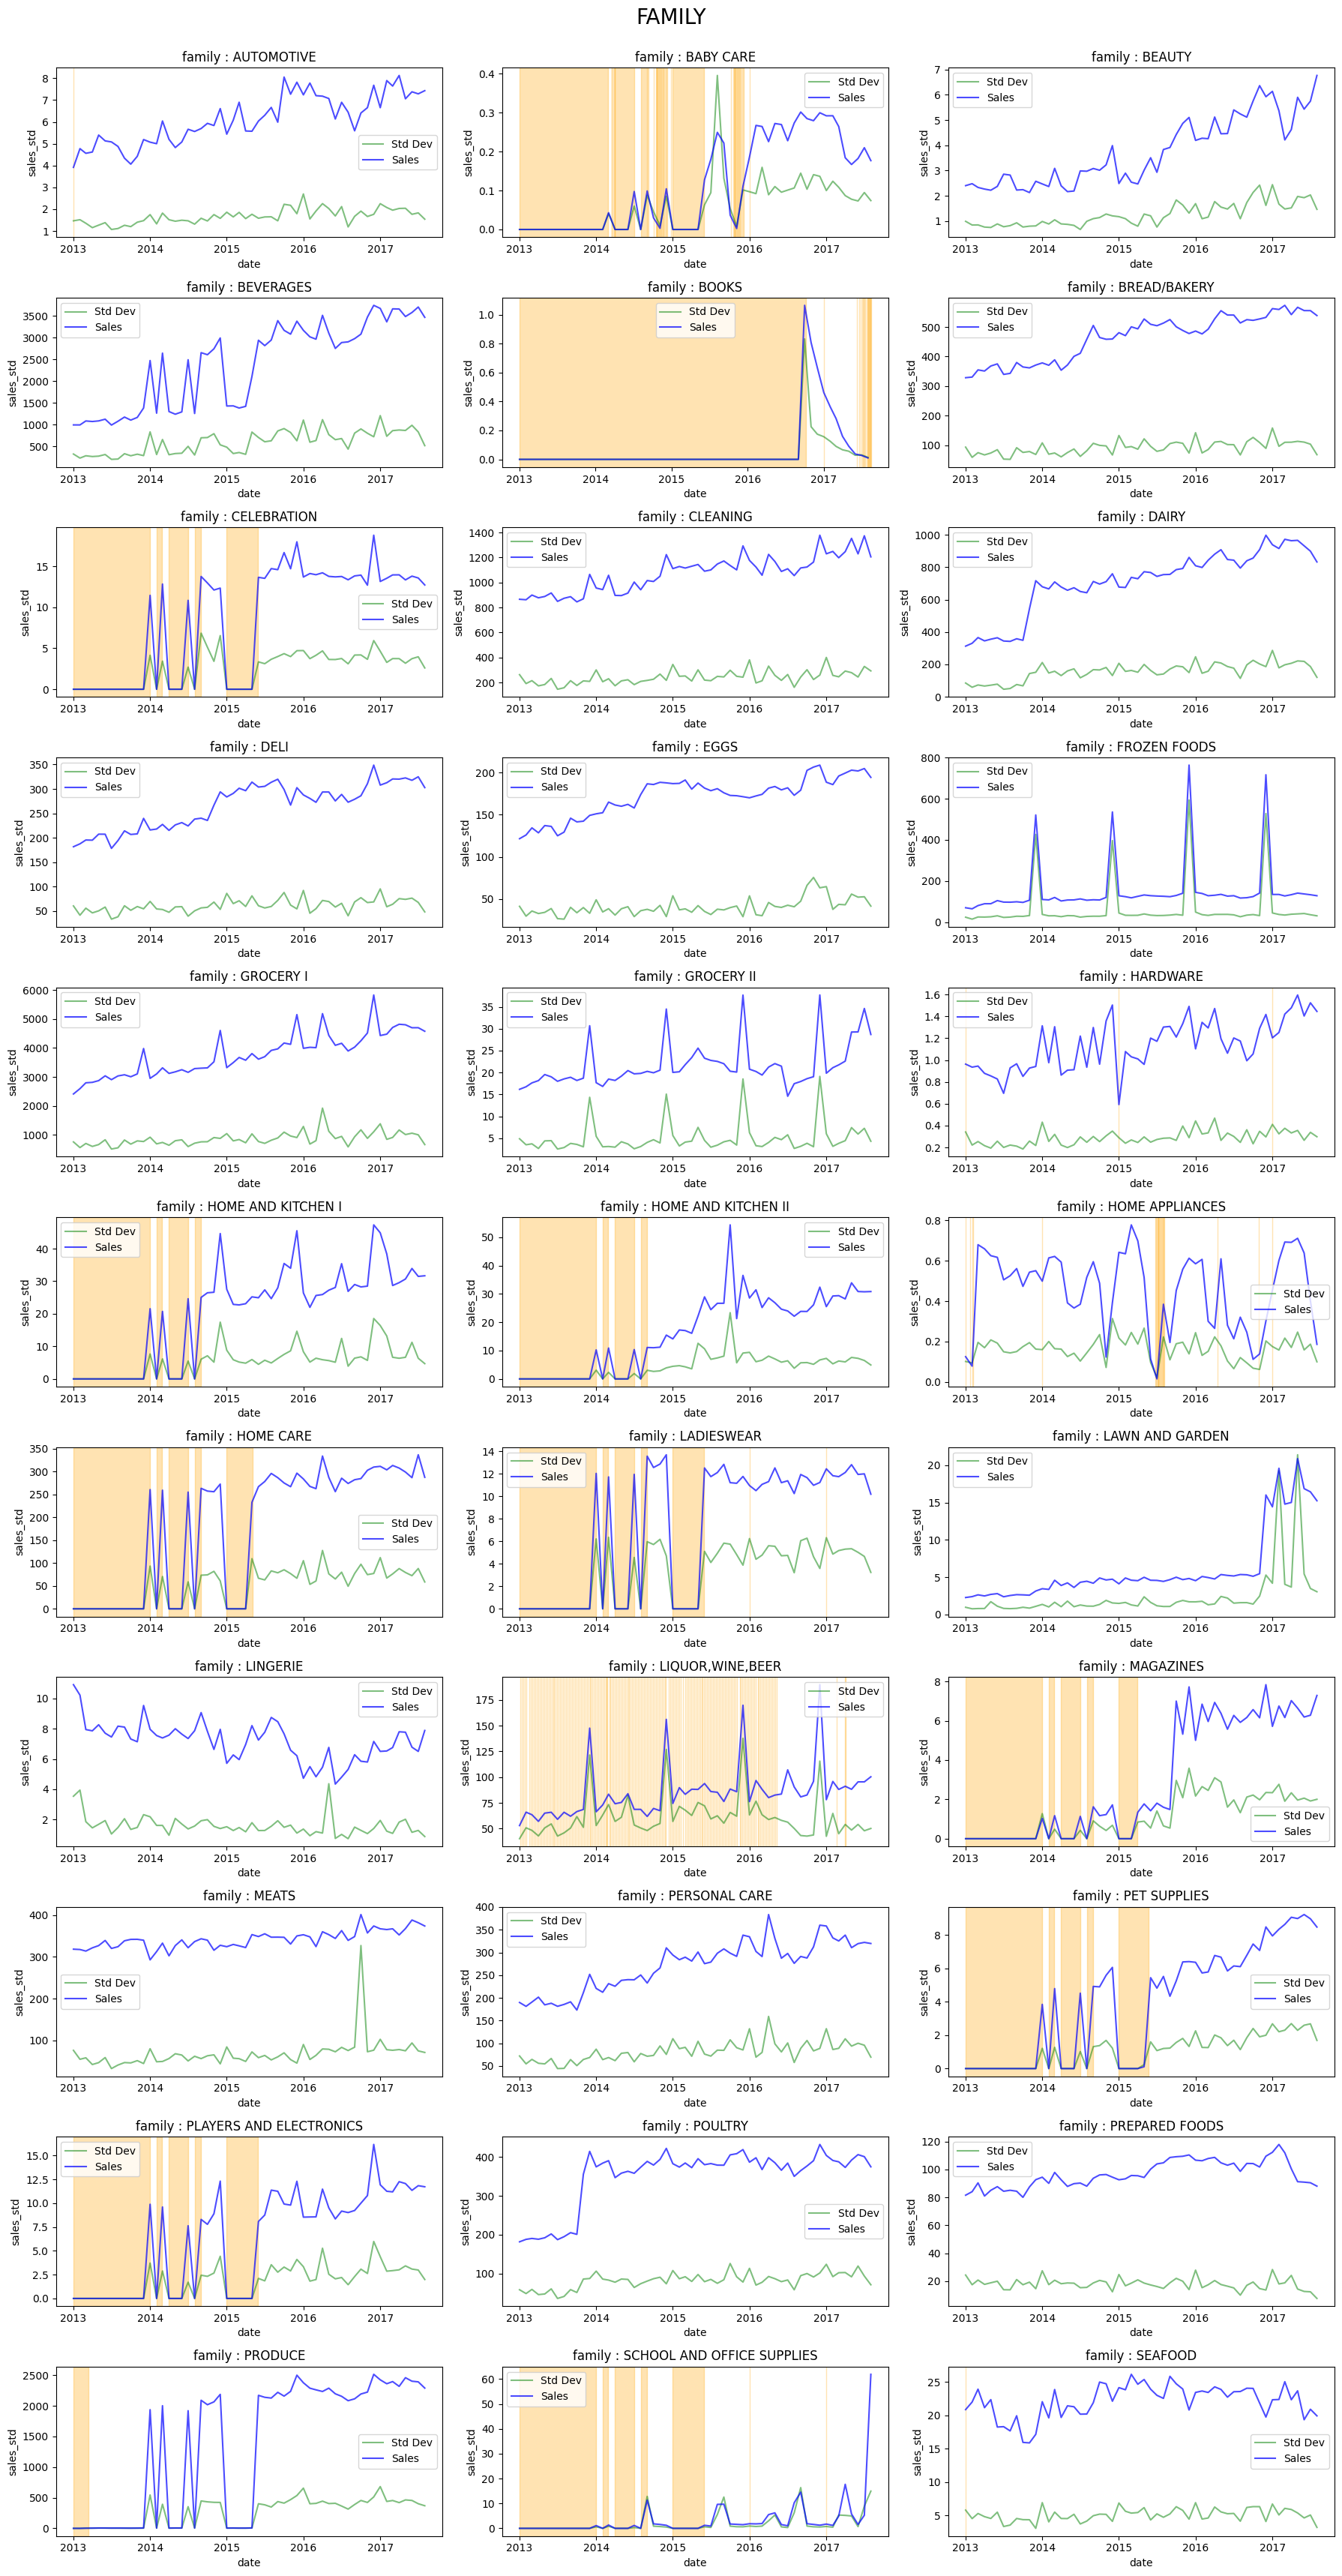

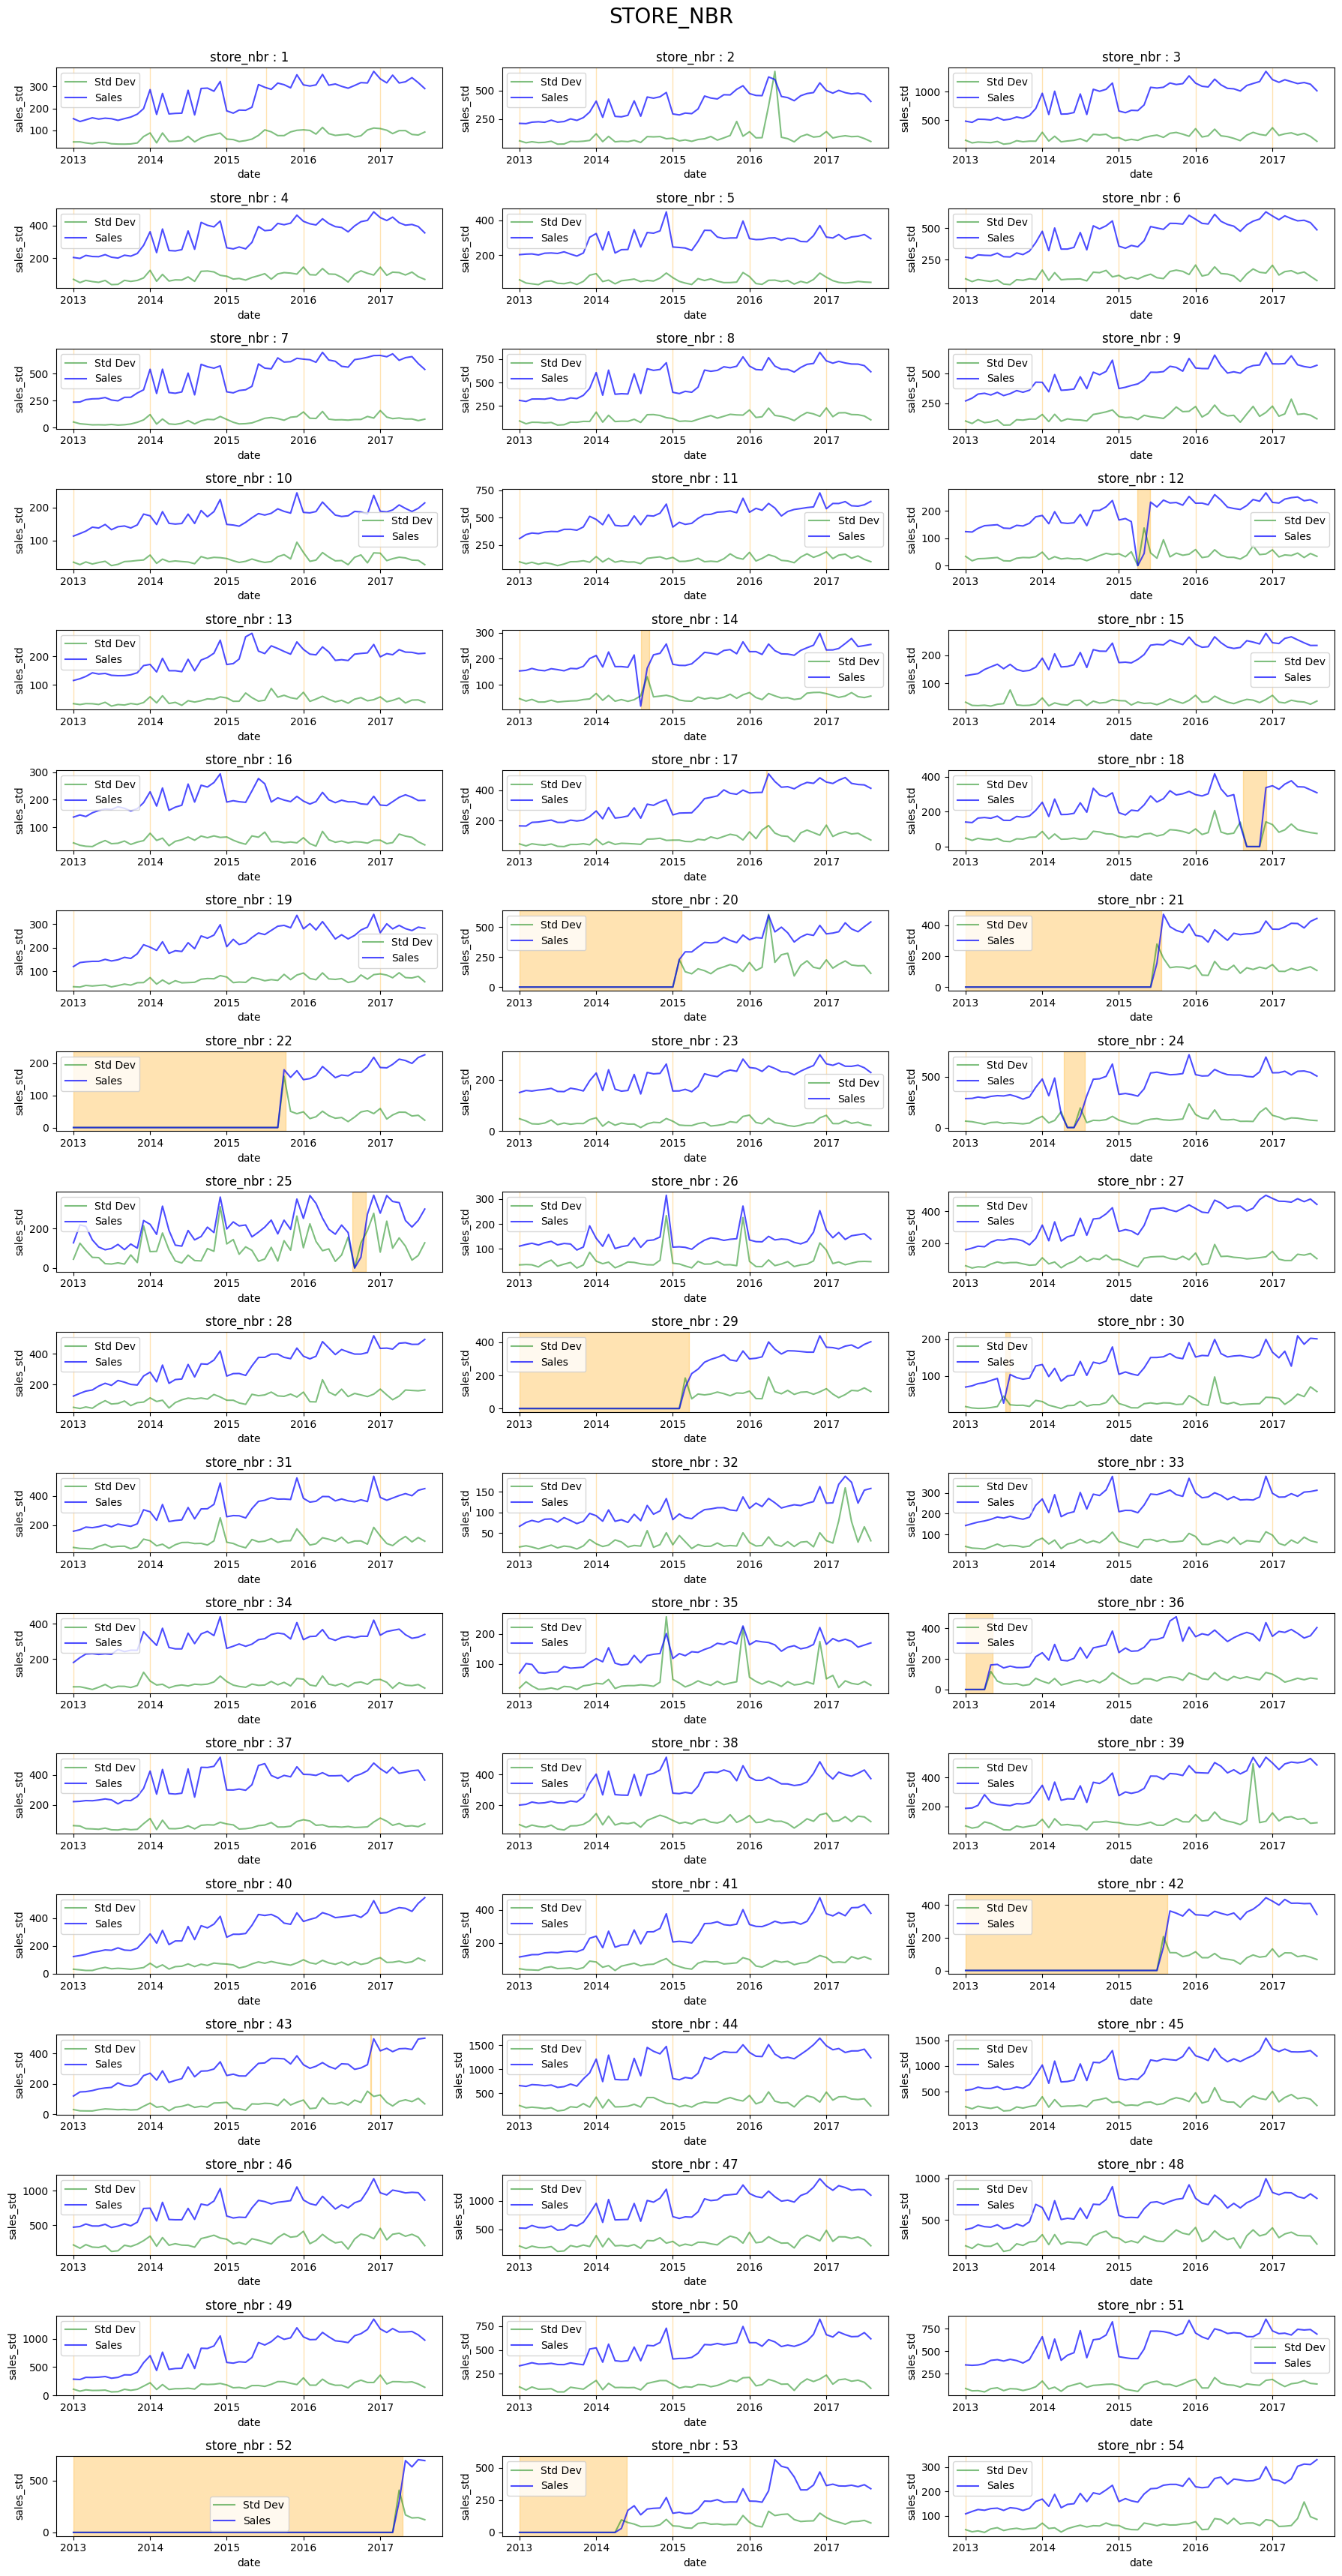

In [16]:
# def week_of_month(dt):
#     first_day = dt.replace(day=1)
#     adjusted_dom = dt.day + first_day.weekday()  # Shift start if month doesn't begin on Monday
#     return int(np.ceil(adjusted_dom / 7.0))

def plot_sales_date(column,num_plots):
    # The following code plots sales vs date for each store,
    # highlighting the date ranges with zero sales as a shaded background.

    train_copy = train.copy()
    train_copy = (train_copy.groupby(['date', column])
                  .agg(sales_sum=('sales','sum'), sales = ('sales','mean'), onpromo=('onpromotion','mean')).reset_index())
    train_copy['month'] = train_copy['date'].dt.month
    train_copy['year'] = train_copy['date'].dt.year
    # train_copy['weekday'] = train_copy['date'].apply(week_of_month) 
    train_copy['sales_mean'] = train_copy.groupby(['month','year', column])['sales'].transform('mean')
    train_copy['sales_std'] = train_copy.groupby(['month','year', column])['sales'].transform('std')
    train_copy['promo_mean'] = train_copy.groupby(['month','year', column])['onpromo'].transform('mean')
    mask = train_copy['date'].dt.day != 1
    train_copy['sales_mean'] = np.where(mask, np.nan, train_copy['sales_mean'])
    train_copy['sales_std'] = np.where(mask, np.nan, train_copy['sales_std'])
    train_copy = train_copy.sort_values(by=[column, 'date'])
    train_copy['is_zero'] = (train_copy['sales_sum'] == 0).astype(int)
    
    # Plot setup
    values = sorted(train_copy[column].unique())
    rows, cols = num_plots
    fig, axs = plt.subplots(rows, cols, figsize=(18, 35))
    axs = axs.flatten()
    
    for i, value in enumerate(values):
        if i >= len(axs):
            break
    
        group = train_copy[train_copy[column] == value]
        ax = axs[i]
        
        sns.lineplot(data=group, x='date', y='sales_std', ax=ax, color='green', label='Std Dev', alpha=0.5)
        sns.lineplot(data=group, x='date', y='sales_mean', ax=ax, color='blue', label='Sales', alpha=0.7)
        ax.set_title(f'{column} : {value}')
        
        # Identify and shade zero-sales periods
        zero_mask = group['is_zero'] == 1
        start = None
        for idx in range(len(group)):
            if zero_mask.iloc[idx] and start is None:
                start = group['date'].iloc[idx]
            elif not zero_mask.iloc[idx] and start is not None:
                end = group['date'].iloc[idx - 1]
                ax.axvspan(start, end, color='orange', alpha=0.3)
                start = None
        if start is not None:
            end = group['date'].iloc[-1]
            ax.axvspan(start, end, color='orange', alpha=0.3)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    fig.suptitle(column.upper(), fontsize=20)
    plt.tight_layout(rect = [0,0,1,0.98])
    plt.show()

plot_sales_date('family',(11,3))
plot_sales_date('store_nbr',(18,3))

Notes on Sales and Standard Deviation Plots
1. Sales Graph: Each data point represents the mean monthly sales.
2. Standard Deviation Graph: Each data point represents the standard deviation of monthly sales, indicating sales variability.
3. Shaded Regions: These highlight periods during which daily sales were zero, helping to identify potential product unavailability, 
    store closures, or temporarily discontinued items. 

Key Observations from Sales vs. Date Plots (by Product Family and Store)
By Product Family:

Trends:
1. Most product families exhibit a general upward trend in sales over time.
2. Some families display abrupt changes—sudden increases or drops in sales.
3. Periodic spikes in families such as frozen food, groceries 1 and 2, liquor and, school and office supplies, suggests seasonal demand patterns.  

Zero-Sales Periods:

Several product families have overlapping periods of continuous zero sales, possibly due to inventory or supply chain issues.
Common families with this pattern include:
Baby Care, Celebration, Home Care, Home and Kitchen 1 & 2, Ladieswear, Liquor, Magazines, Pet Supplies, Electronics, School and Office Supplies.

New-Stores:

A few of the stores are relatively new. Stores 20, 21, 22, 29 and 42 were opened in 2015, whereas store 53 and store 52 started operating
2014 and 2017 respectively.  

# Sales Distribution

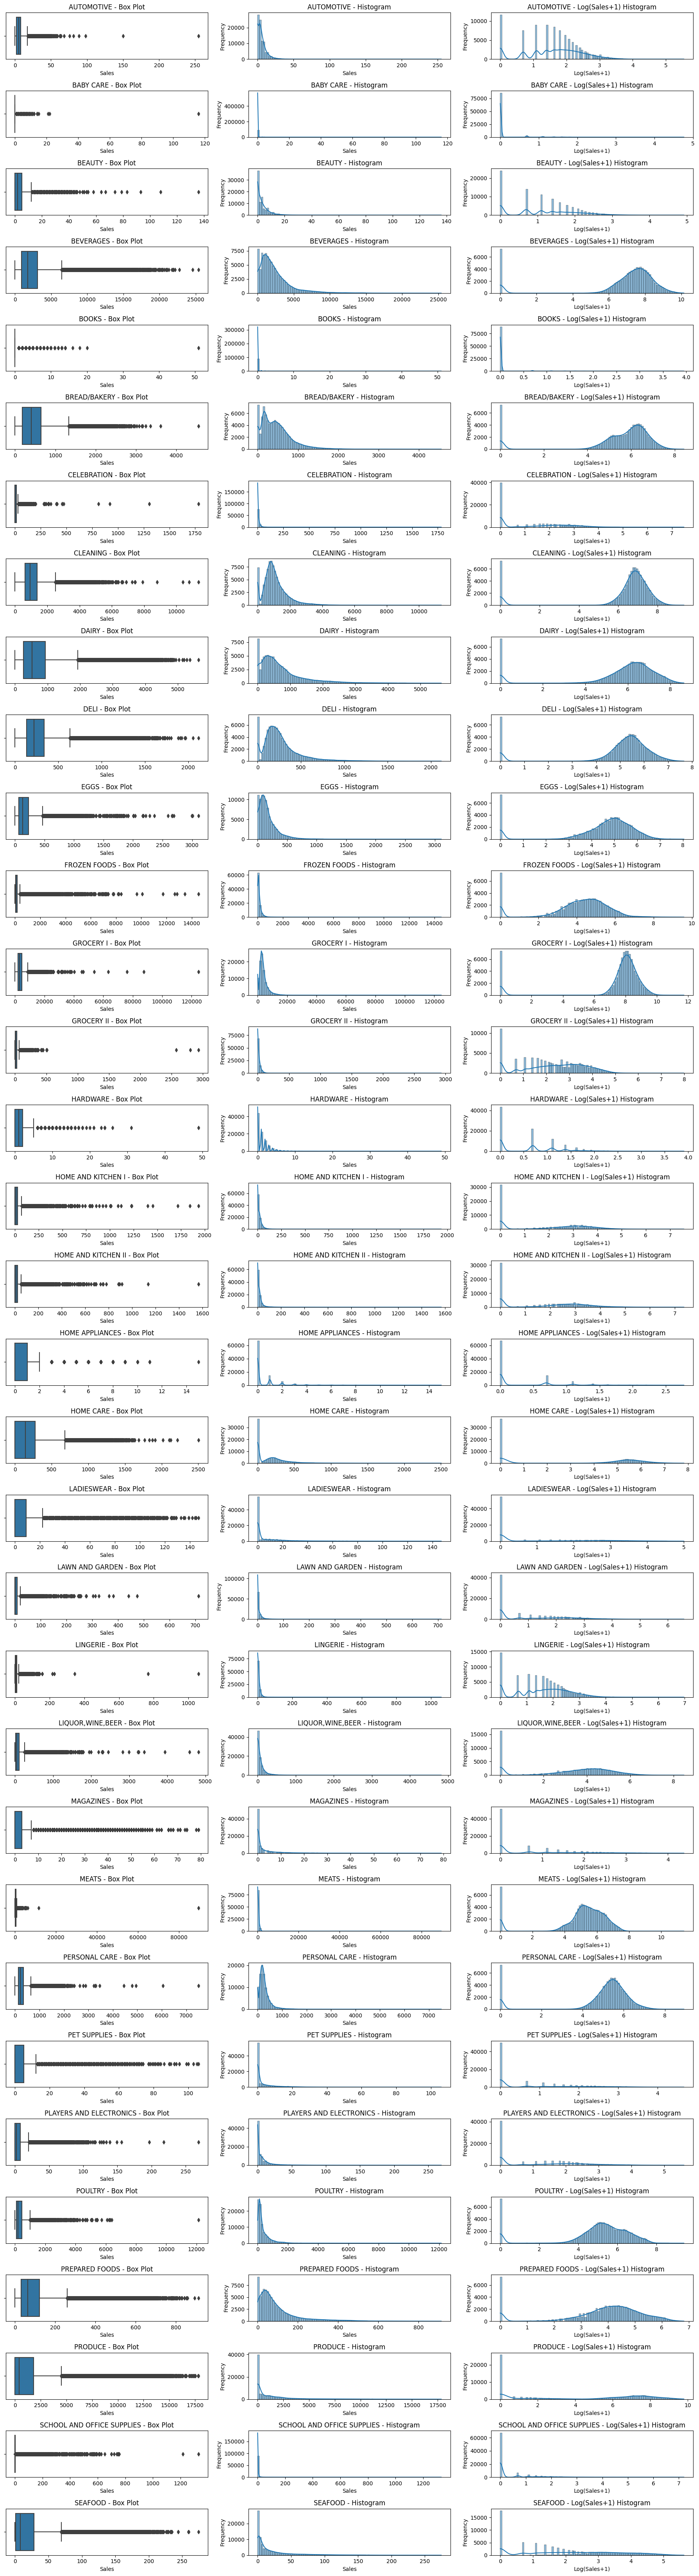

In [17]:
groups = train.groupby('family')
n = len(groups)
fig, axs = plt.subplots(n, 3, figsize=(18, n * 2))
axs = axs.reshape(n, 3)

for i, (family, group) in enumerate(groups):
    
    # Box plot
    sns.boxplot(x=group['sales'], ax=axs[i, 0])
    axs[i, 0].set_title(f"{family} - Box Plot")
    axs[i, 0].set_xlabel("Sales")
    
    # Histogram
    sns.histplot(group['sales'], bins=100, kde=True, ax=axs[i, 1])
    axs[i, 1].set_title(f"{family} - Histogram")
    axs[i, 1].set_xlabel("Sales")
    axs[i, 1].set_ylabel("Frequency")

    # Log-transformed histogram
    sns.histplot(np.log1p(group['sales']), bins=100, kde=True, ax=axs[i, 2])
    axs[i, 2].set_title(f"{family} - Log(Sales+1) Histogram")
    axs[i, 2].set_xlabel("Log(Sales+1)")
    axs[i, 2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


The sales data is highly skewed, with a large number of low sales values and a relatively small number of extremely high values. This can cause challenges
for models like XGBoost, which rely on minimizing error gradients. In particular, high sales are underrepresented, meaning the model has fewer 
opportunities to learn from these cases. At the same time, their large magnitudes can produce disproportionately large errors during training, leading the
model to overemphasize these rare instances at the expense of learning general patterns across the more common, lower sales
values.

To deal with these issues, a log transformation was applied to the sales variable. This transformation compresses high sales values, pulling them closer 
to the core of the distribution. At the same time, it spreads out the lower, more frequent values, making them more distinguishable and allowing the model to
capture finer differences in these dense regions. Overall, the transformation reduces skewness and helps create a more balanced distribution of values for
the model to learn from.

Despite these benefits, it is important to note that extremely large sales values may still impact model performance. Even after the log transformation, 
outliers can generate large residuals, which XGBoost tends to prioritize due to its gradient boosting nature. These high-error points may skew the 
training process by forcing the model to focus disproportionately on minimizing their error.

A significant portion of the zero sales entries in the dataset can be partially attributed to stores that began operating at later dates. These newly 
opened stores naturally recorded zero sales prior to their launch, resulting in extended periods with no activity in the data. For instance, stores such 
as 20, 21, 22, 29, and 42 only began operations in 2015, while store 52 is the most recent addition, having opened in 2017. These gaps do not indicate 
poor performance or product unavailability.

# Holidays

In [18]:
for column in set(holidays.columns)-{'date'}:
    print(f"{column}: {holidays[column].unique()}")
    print('\n')

locale_name: ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']


locale: ['Local' 'Regional' 'National']


type: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']


transferred: [False  True]


description: ['Fundacion de Manta' 'Provincializacion de Cotopaxi'
 'Fundacion de Cuenca' 'Cantonizacion de Libertad'
 'Cantonizacion de Riobamba' 'Cantonizacion del Puyo'
 'Cantonizacion de Guaranda' 'Provincializacion de Imbabura'
 'Cantonizacion de Latacunga' 'Fundacion de Machala'
 'Fundacion de Santo Domingo' 'Cantonizacion de El Carmen'
 'Cantonizacion de Cayambe' 'Fundacion de Esmeraldas'
 'Primer Grito de Independencia' 'Fundacion de Riobamba'
 'Fundacion de Ambato' 'Fundacion de Ibarra' 'Cantonizacion de Quevedo'
 'Independencia de Guayaquil' 'Tra

In [19]:
print('Counts of each combination of holiday type and holiday locale:\n')
print('All holidays and events: transferred and untransferred:\n')
data = holidays.groupby(['locale','type'])[['locale','type']].value_counts().unstack()
print(data)
print()
print('Only untransferred holidays and events:\n')
data = holidays[holidays['transferred']==False].groupby(['locale','type'])[['locale','type']].value_counts().unstack()
print(data)

Counts of each combination of holiday type and holiday locale:

All holidays and events: transferred and untransferred:

type      Additional  Bridge  Event  Holiday  Transfer  Work Day
locale                                                          
Local           11.0     NaN    NaN    137.0       4.0       NaN
National        40.0     5.0   56.0     60.0       8.0       5.0
Regional         NaN     NaN    NaN     24.0       NaN       NaN

Only untransferred holidays and events:

type      Additional  Bridge  Event  Holiday  Transfer  Work Day
locale                                                          
Local           11.0     NaN    NaN    133.0       4.0       NaN
National        40.0     5.0   56.0     52.0       8.0       5.0
Regional         NaN     NaN    NaN     24.0       NaN       NaN


Holiday Type Definitions:

Holiday: Official public holiday when most businesses close.

Event: Informal or cultural occasions (e.g., sports matches, local festivals).

Additional: Non-regular holidays added in specific years.

Bridge: Days off used to connect holidays with weekends.

Transfer: Holidays shifted from their original date to another.

Work: Days declared as working days, often to compensate for bridge holidays.

Local holidays constitute the largest share of all holidays, followed by national events and then national holidays. Only holidays have been 
shifted — events remain on their original dates within the provided date range. The number of regional holidays seem small enough for the model to 
potentially underfit on them, yet not so small that this underfitting can be ignored.

In [20]:
# The holiday names are in Spanish so they have to be translated to English before they are analyzed.

# The following dictionary helps translate the names to English.

translation_map = {
    'Fundacion de Manta': 'Founding of Manta',
    'Provincializacion de Cotopaxi': 'Provincehood of Cotopaxi',
    'Fundacion de Cuenca': 'Founding of Cuenca',
    'Cantonizacion de Libertad': 'Cantonization of Libertad',
    'Cantonizacion de Riobamba': 'Cantonization of Riobamba',
    'Cantonizacion del Puyo': 'Cantonization of Puyo',
    'Cantonizacion de Guaranda': 'Cantonization of Guaranda',
    'Provincializacion de Imbabura': 'Provincehood of Imbabura',
    'Cantonizacion de Latacunga': 'Cantonization of Latacunga',
    'Fundacion de Machala': 'Founding of Machala',
    'Fundacion de Santo Domingo': 'Founding of Santo Domingo',
    'Cantonizacion de El Carmen': 'Cantonization of El Carmen',
    'Cantonizacion de Cayambe': 'Cantonization of Cayambe',
    'Fundacion de Esmeraldas': 'Founding of Esmeraldas',
    'Primer Grito de Independencia': 'First Cry of Independence',
    'Fundacion de Riobamba': 'Founding of Riobamba',
    'Fundacion de Ambato': 'Founding of Ambato',
    'Fundacion de Ibarra': 'Founding of Ibarra',
    'Cantonizacion de Quevedo': 'Cantonization of Quevedo',
    'Independencia de Guayaquil': 'Independence of Guayaquil',
    'Traslado Independencia de Guayaquil': 'Transferred Independence of Guayaquil',
    'Dia de Difuntos': 'All Souls Day',
    'Independencia de Cuenca': 'Independence of Cuenca',
    'Provincializacion de Santo Domingo': 'Provincehood of Santo Domingo',
    'Provincializacion Santa Elena': 'Provincehood of Santa Elena',
    'Independencia de Guaranda': 'Independence of Guaranda',
    'Independencia de Latacunga': 'Independence of Latacunga',
    'Independencia de Ambato': 'Independence of Ambato',
    'Fundacion de Quito-1': 'Founding of Quito-1',
    'Fundacion de Quito': 'Founding of Quito',
    'Fundacion de Loja': 'Founding of Loja',
    'Navidad-4': 'Christmas-4',
    'Cantonizacion de Salinas': 'Cantonization of Salinas',
    'Navidad-3': 'Christmas-3',
    'Navidad-2': 'Christmas-2',
    'Puente Navidad': 'Christmas Bridge',
    'Navidad-1': 'Christmas-1',
    'Navidad': 'Christmas',
    'Navidad+1': 'Christmas+1',
    'Puente Primer dia del ano': 'Bridge New Year\'s Day',
    'Primer dia del ano-1': 'New Year\'s Day-1',
    'Primer dia del ano': 'New Year\'s Day',
    'Recupero puente Navidad': 'Recovery Day Christmas Bridge',
    'Recupero puente primer dia del ano': 'Recovery Day New Year\'s Bridge',
    'Carnaval': 'Carnival',
    'Viernes Santo': 'Good Friday',
    'Dia del Trabajo': 'Labor Day',
    'Dia de la Madre-1': 'Mother\'s Day-1',
    'Dia de la Madre': 'Mother\'s Day',
    'Batalla de Pichincha': 'Battle of Pichincha',
    'Fundacion de Guayaquil-1': 'Founding of Guayaquil-1',
    'Fundacion de Guayaquil': 'Founding of Guayaquil',
    'Inauguracion Mundial de futbol Brasil': 'World Cup Opening - Brazil',
    'Mundial de futbol Brasil: Ecuador-Suiza': 'World Cup: Ecuador-Switzerland',
    'Mundial de futbol Brasil: Ecuador-Honduras': 'World Cup: Ecuador-Honduras',
    'Mundial de futbol Brasil: Ecuador-Francia': 'World Cup: Ecuador-France',
    'Mundial de futbol Brasil: Octavos de Final': 'World Cup: Round of 16',
    'Mundial de futbol Brasil: Cuartos de Final': 'World Cup: Quarter Finals',
    'Mundial de futbol Brasil: Semifinales': 'World Cup: Semifinals',
    'Mundial de futbol Brasil: Tercer y cuarto lugar': 'World Cup: 3rd Place Match',
    'Mundial de futbol Brasil: Final': 'World Cup: Final',
    'Black Friday': 'Black Friday',
    'Cyber Monday': 'Cyber Monday',
    'Recupero Puente Navidad': 'Recovery Day Christmas Bridge',
    'Recupero Puente Primer dia del ano': 'Recovery Day New Year\'s Bridge',
    'Terremoto Manabi': 'Manabi Earthquake',
    'Terremoto Manabi+1': 'Manabi Earthquake+1',
    'Terremoto Manabi+2': 'Manabi Earthquake+2',
    'Terremoto Manabi+3': 'Manabi Earthquake+3',
    'Terremoto Manabi+4': 'Manabi Earthquake+4',
    'Terremoto Manabi+5': 'Manabi Earthquake+5',
    'Terremoto Manabi+6': 'Manabi Earthquake+6',
    'Terremoto Manabi+7': 'Manabi Earthquake+7',
    'Terremoto Manabi+8': 'Manabi Earthquake+8',
    'Terremoto Manabi+9': 'Manabi Earthquake+9',
    'Terremoto Manabi+10': 'Manabi Earthquake+10',
    'Terremoto Manabi+11': 'Manabi Earthquake+11',
    'Terremoto Manabi+12': 'Manabi Earthquake+12',
    'Terremoto Manabi+13': 'Manabi Earthquake+13',
    'Terremoto Manabi+14': 'Manabi Earthquake+14',
    'Terremoto Manabi+15': 'Manabi Earthquake+15',
    'Terremoto Manabi+16': 'Manabi Earthquake+16',
    'Terremoto Manabi+17': 'Manabi Earthquake+17',
    'Terremoto Manabi+18': 'Manabi Earthquake+18',
    'Terremoto Manabi+19': 'Manabi Earthquake+19',
    'Terremoto Manabi+20': 'Manabi Earthquake+20',
    'Terremoto Manabi+21': 'Manabi Earthquake+21',
    'Terremoto Manabi+22': 'Manabi Earthquake+22',
    'Terremoto Manabi+23': 'Manabi Earthquake+23',
    'Terremoto Manabi+24': 'Manabi Earthquake+24',
    'Terremoto Manabi+25': 'Manabi Earthquake+25',
    'Terremoto Manabi+26': 'Manabi Earthquake+26',
    'Terremoto Manabi+27': 'Manabi Earthquake+27',
    'Terremoto Manabi+28': 'Manabi Earthquake+28',
    'Terremoto Manabi+29': 'Manabi Earthquake+29',
    'Terremoto Manabi+30': 'Manabi Earthquake+30',
    'Traslado Batalla de Pichincha': 'Transferred Battle of Pichincha',
    'Traslado Fundacion de Guayaquil': 'Transferred Founding of Guayaquil',
    'Traslado Primer Grito de Independencia': 'Transferred First Cry of Independence',
    'Puente Dia de Difuntos': 'All Souls Day Bridge',
    'Recupero Puente Dia de Difuntos': 'Recovery Day All Souls Bridge',
    'Traslado Primer dia del ano': 'Transferred New Year\'s Day',
    'Traslado Fundacion de Quito': 'Transferred Founding of Quito'
}

holidays['description'] = holidays['description'].replace(translation_map)

To understand the impact of holidays on sales across different product families, I calculated the ratio of sales on each holiday to the average sales of the surrounding non-holiday days. This approach helps isolate the effect of the holiday itself from general sales trends. For each holiday, I 
computed both the mean and the coefficient of variation of these sales ratios across multiple years. While the mean captures the average impact of the 
holiday on sales, the coefficient of variation provides insight into the consistency of that impact over time. A low coefficient of variation indicates a stable and predictable influence, whereas a high value suggests that the holiday's effect on sales is more irregular or is affected by other factors. It must be noted that non-holidays can still experience spike in sales beacuse of factors such as onpromotion. 

In [21]:
def create_sales_ratio(holidays_data, local):
    
    # The location details in stores dataframe are requried to appropriately match the sales with respective holidays. 
    df = pd.merge(train,stores, on='store_nbr', how='left')
    
    #Some of the holidays were transferred from from their original date so the dates on which they were supposed to occur need to be removed.
    holidays_data = holidays_data[holidays_data['transferred'] == False]
    
    if local == 'National':
        df = pd.merge(df,holidays_data, on='date', how='left')
    elif local == 'Regional':
        df = pd.merge(df,holidays_data, left_on=['date','state'], right_on=['date','locale_name'], how='left')
    elif local == 'Local':
        df = pd.merge(df,holidays_data, left_on=['date','city'], right_on=['date','locale_name'], how='left')
    
    # Create a mask for non-holiday rows
    non_holiday_mask = df['locale_name'].isna()
    
    # Apply shift only to non-holidays
    for i in list(range(5,15))+list(range(-5,-15,-1)):
        df.loc[non_holiday_mask, f'prev_day_{i}_sales'] = df.loc[non_holiday_mask].groupby(['family','store_nbr'])['sales'].shift(i)
    
    # Forward-fill the NaN values in holiday rows using the last available non-holiday value
    prev_day = [f'prev_day_{i}_sales' for i in list(range(5,15))+list(range(-5,-15,-1))]
    df[prev_day] = df.groupby(['family', 'store_nbr'])[prev_day].fillna(method='ffill')
    
    df['avg_sales'] = df[prev_day].mean(axis=1)
    
    df = df[(df['avg_sales']!=0)]
    df['sales_ratio'] = df['sales']/df['avg_sales']
    return df

In [22]:
def iqr_mean(group):
    column = 'sales_ratio'
    q1 = group[column].quantile(0.25)
    q3 = group[column].quantile(0.75)
    iqr = q3 - q1
    data = group[(group[column]>q1-1.5*iqr) & (group[column]<=q3+1.5*iqr)]
    if data.shape[0] == 0:
        return group[column].mean()
    else:
        return data[column].mean()

def iqr_std(group):
    column = 'sales_ratio'
    q1 = group[column].quantile(0.25)
    q3 = group[column].quantile(0.75)
    iqr = q3 - q1
    data = group[(group[column]>q1-1.5*iqr) & (group[column]<=q3+1.5*iqr)]
    if data.shape[0] == 0:
        return group[column].std()
    else:
        return data[column].std()

In [23]:
def create_holiday_heatmaps(row_num, col_num, fig_size, locale, hol_type):
    fig, axes = plt.subplots(row_num, col_num, figsize=fig_size)
    
    # Filter for national holidays
    holidays_subset = holidays[(holidays['locale'] == locale) & (holidays['type'] == hol_type)]
    sr_df = create_sales_ratio(holidays_subset, locale)
    
    data = sr_df[(sr_df['locale'] == locale) & (sr_df['type_y'] == hol_type)]
    grouped = data.groupby(['family', 'description'])
    
    # Mean sales ratio heatmap
    pivot_mean = grouped.apply(iqr_mean).unstack()
    sns.heatmap(pivot_mean, cmap='viridis', annot=True, fmt=".2f", vmin=0, vmax=1.5, ax=axes[0], cbar_kws={'shrink': 1, 'aspect': 80})
    axes[0].set_title(f"Mean of Sales Ratio during {locale} {hol_type}s")
    axes[0].set_xlabel("Holiday Description")
    axes[0].set_ylabel("Product Family")
    axes[0].tick_params(axis='x', rotation=45)
    
    # Coefficient of variation heatmap (std / mean)
    pivot_cv = (grouped.apply(iqr_std) / grouped.apply(iqr_mean)).unstack()
    sns.heatmap(pivot_cv, cmap='viridis', annot=True, fmt=".2f", vmin=0, vmax=1, ax=axes[1], cbar_kws={'shrink': 1, 'aspect': 80})
    axes[1].set_title(f"Coefficient of Variation of Sales Ratio during {locale} {hol_type}s")
    axes[1].set_xlabel("Holiday Description")
    axes[1].set_ylabel("Product Family")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

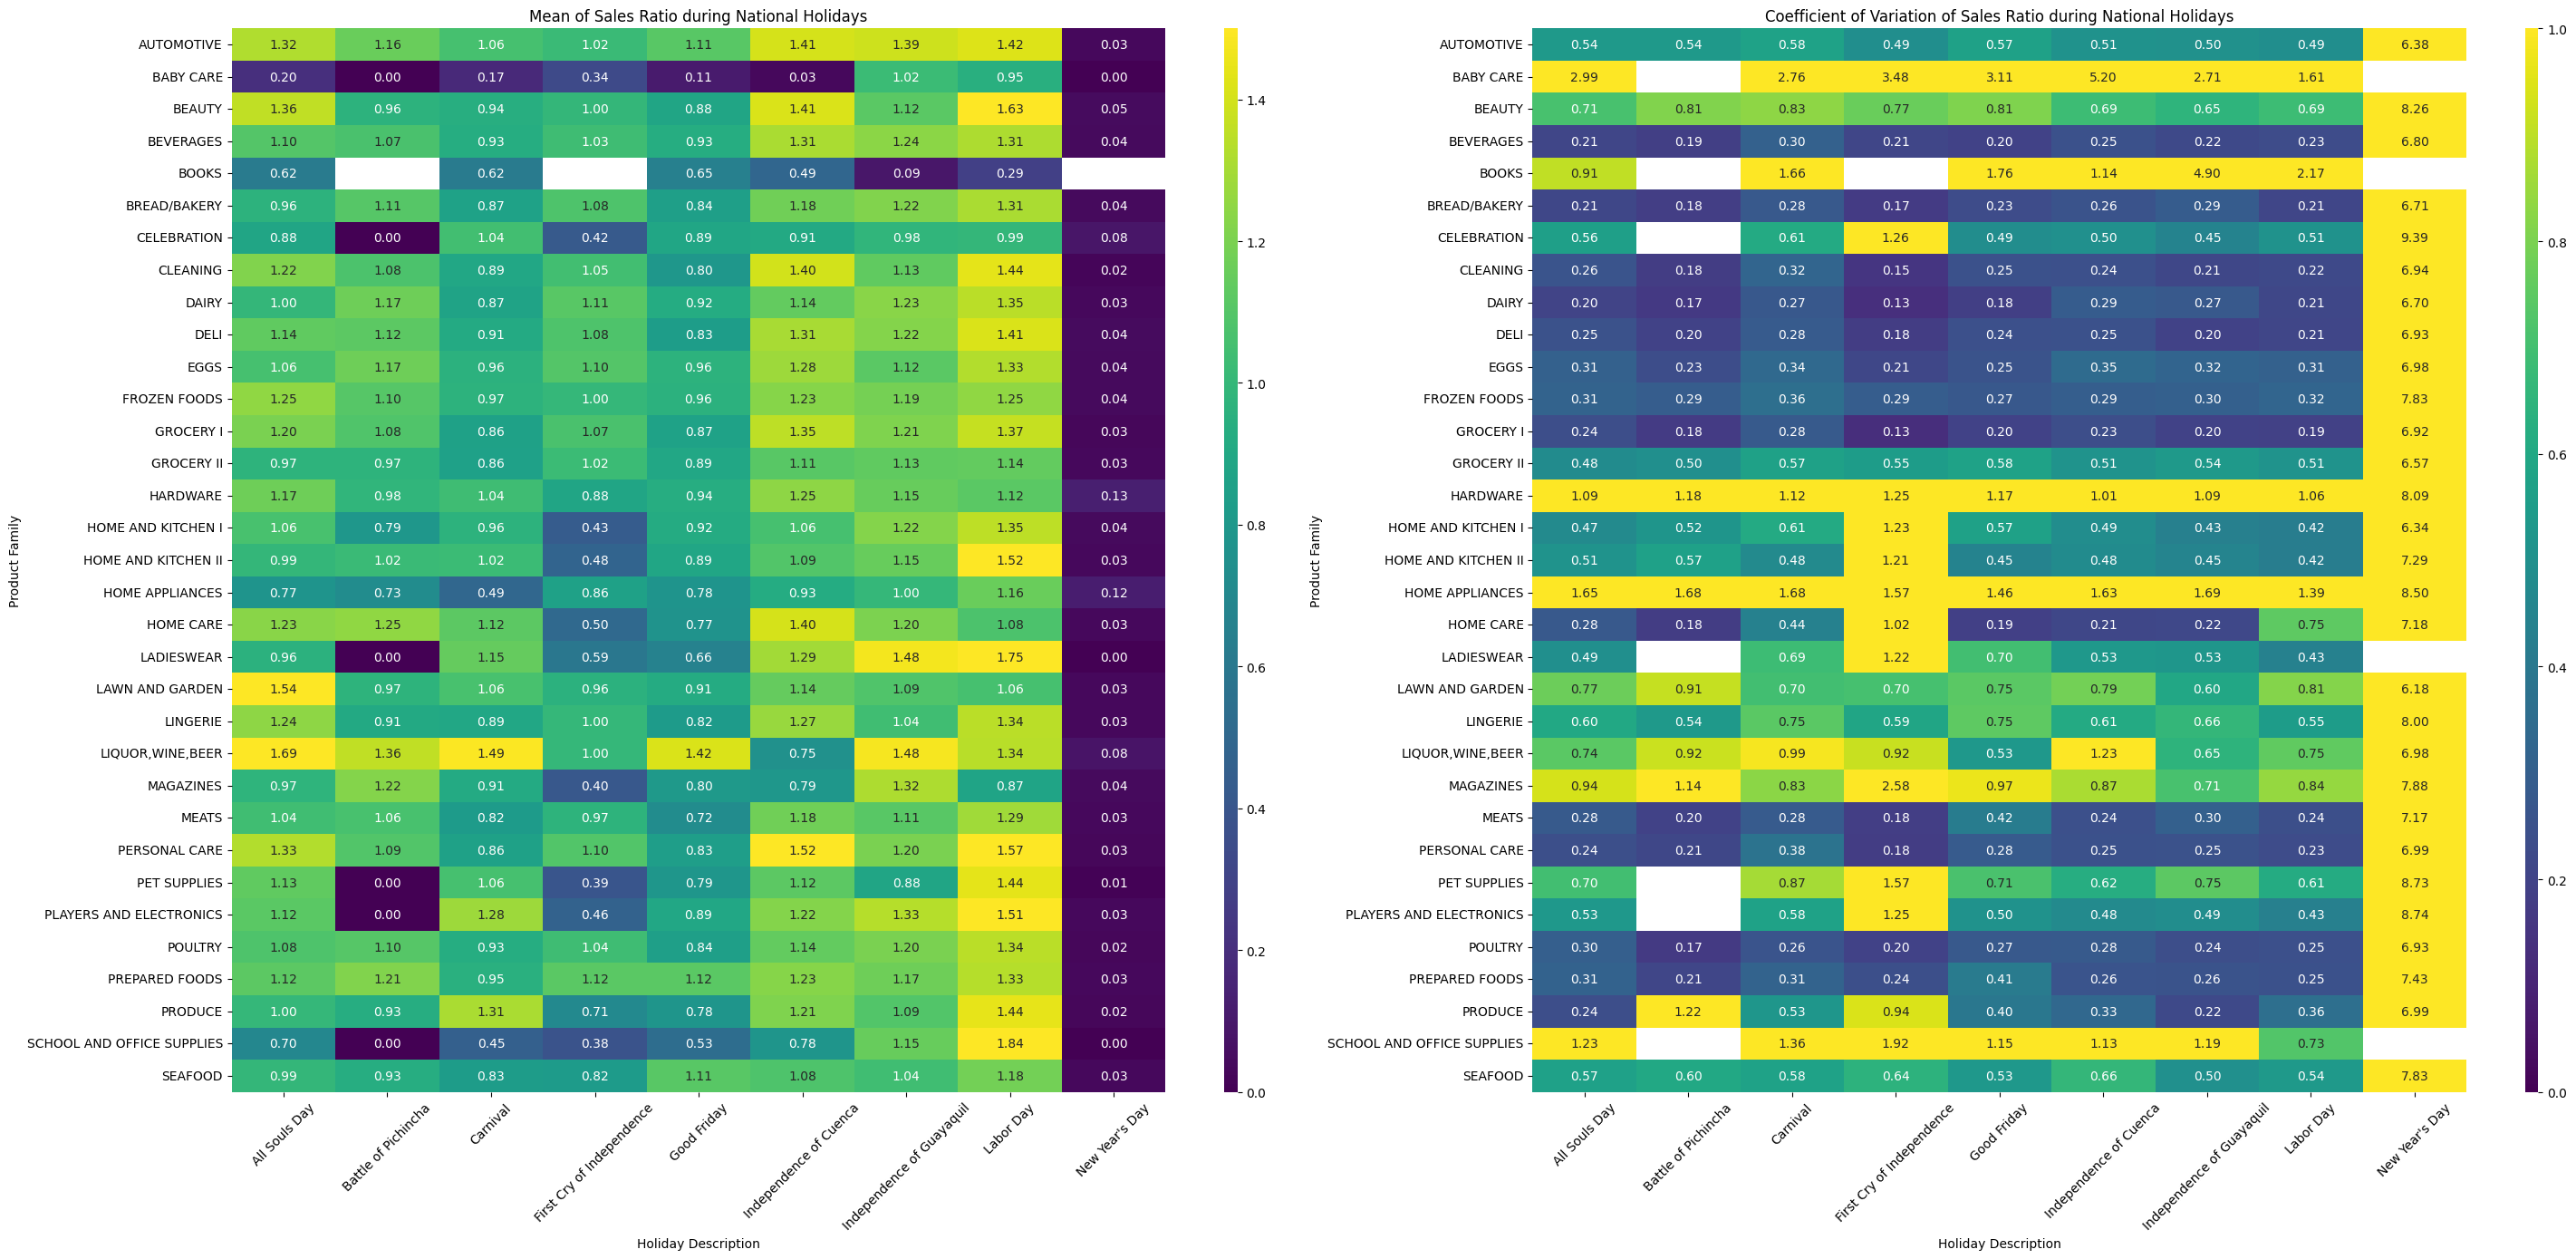

In [24]:
# Creates heatmap of sales ratio by national holiday and product family

create_holiday_heatmaps(1, 2, (30,14), 'National', 'Holiday')

The gaps in the heatmap arise from the removal of values, because the average sales on the days surrounding the holiday was zero, making the ratio 
undefined. Among the national holidays, most exhibit relatively consistent behavior across different product families, with a few notable exceptions. 
Labor Day stands out by showing a moderately higher sales ratio compared to other holidays, coupled with moderate to low variability, suggesting a stable increase in demand. In contrast, First Cry of Independence is marked by very high variability for nearly half of the product families, indicating inconsistent holiday effects across years. Good Friday, on the other hand, is associated with generally low sales ratios and moderate to high variability across all product families, suggesting that it may suppress consumer activity or be influenced by non-shopping cultural norms.

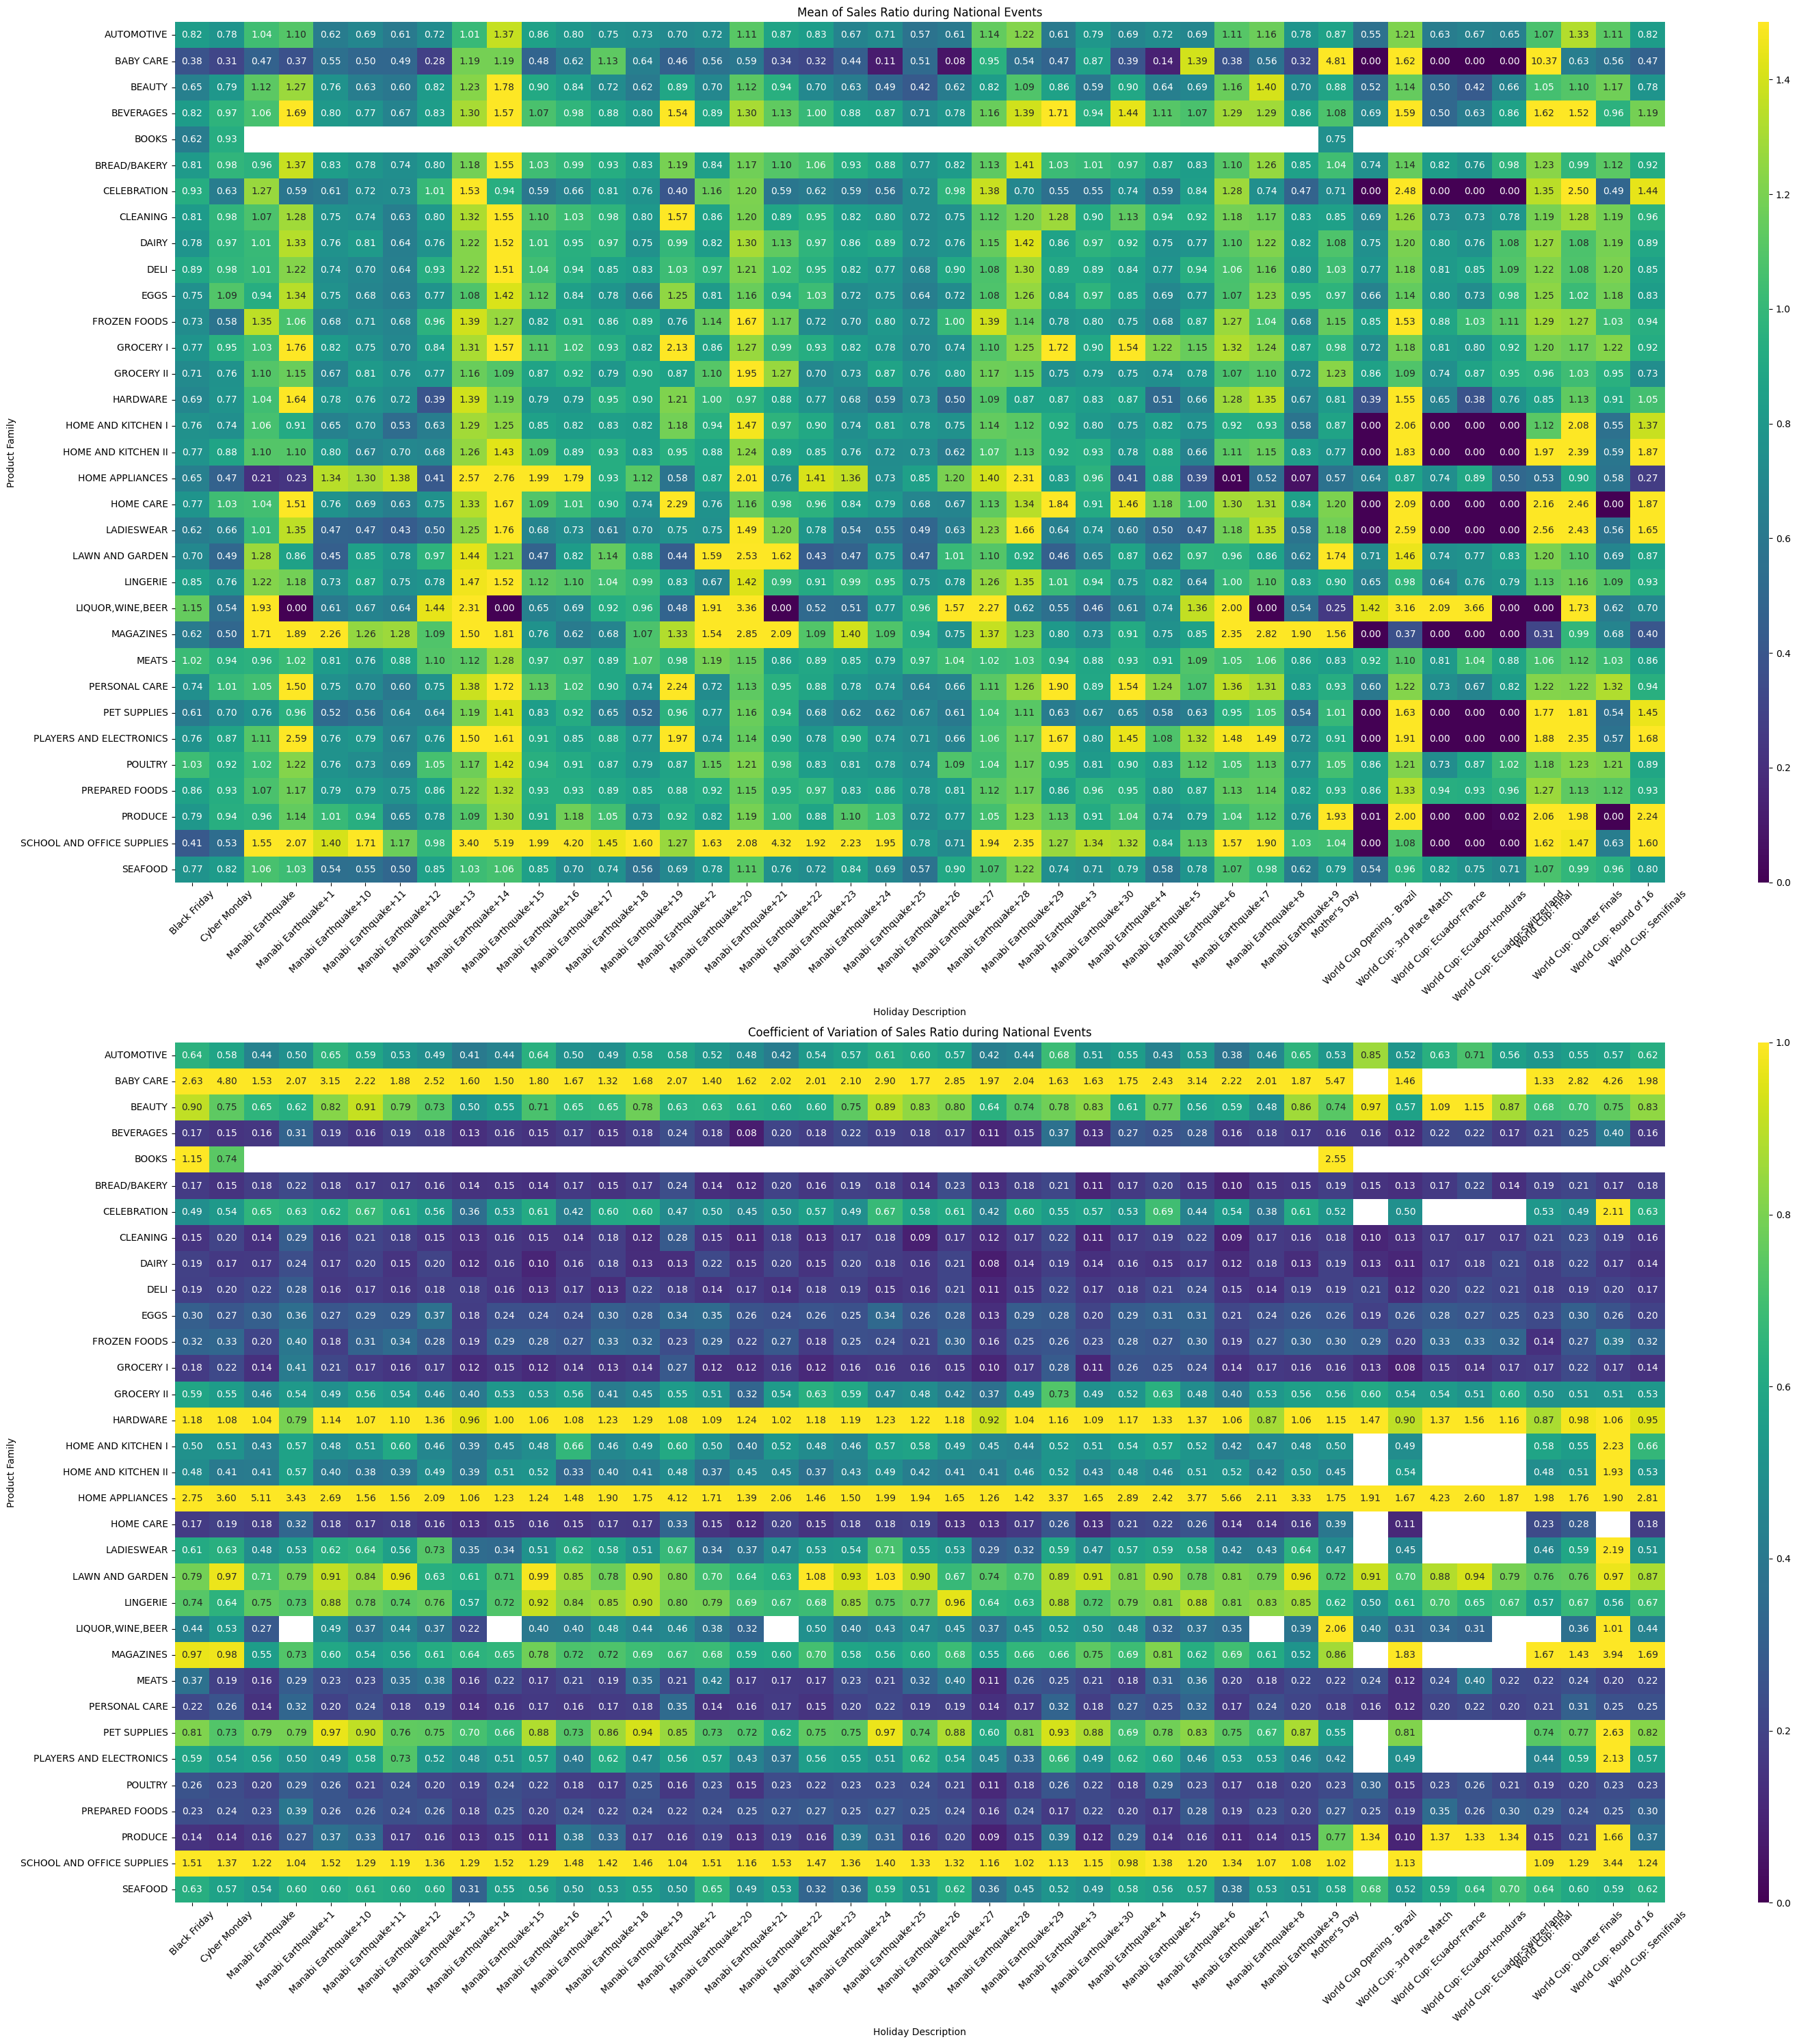

In [25]:
# Creates heatmap of sales ratio by national event and product family

create_holiday_heatmaps(2, 1, (30, 30), 'National', 'Event')

Black Friday and Cyber Monday surprisingly register consistently low sales across all product families. In contrast, the earthquake relief programme is associated with consistently high sales across nearly all stores for specific families like Grocery 1, Personal Care, and Players and Electronics, with notably low variability — indicating a uniform response across regions. Home Appliances and School and Office Supplies also show elevated sales during the relief period, but with high coefficients of variation, pointing to inconsistent sales patterns likely driven by localized needs or supply constraints. As expected, Mother’s Day leads to strong spikes in categories such as Lawn and Garden, Ladieswear, and Home Care, reflecting typical consumer gifting behavior. Lastly, Football Matches tend to drive up sales in Celebration and Liquor categories, aligning with social and event-driven consumption trends.

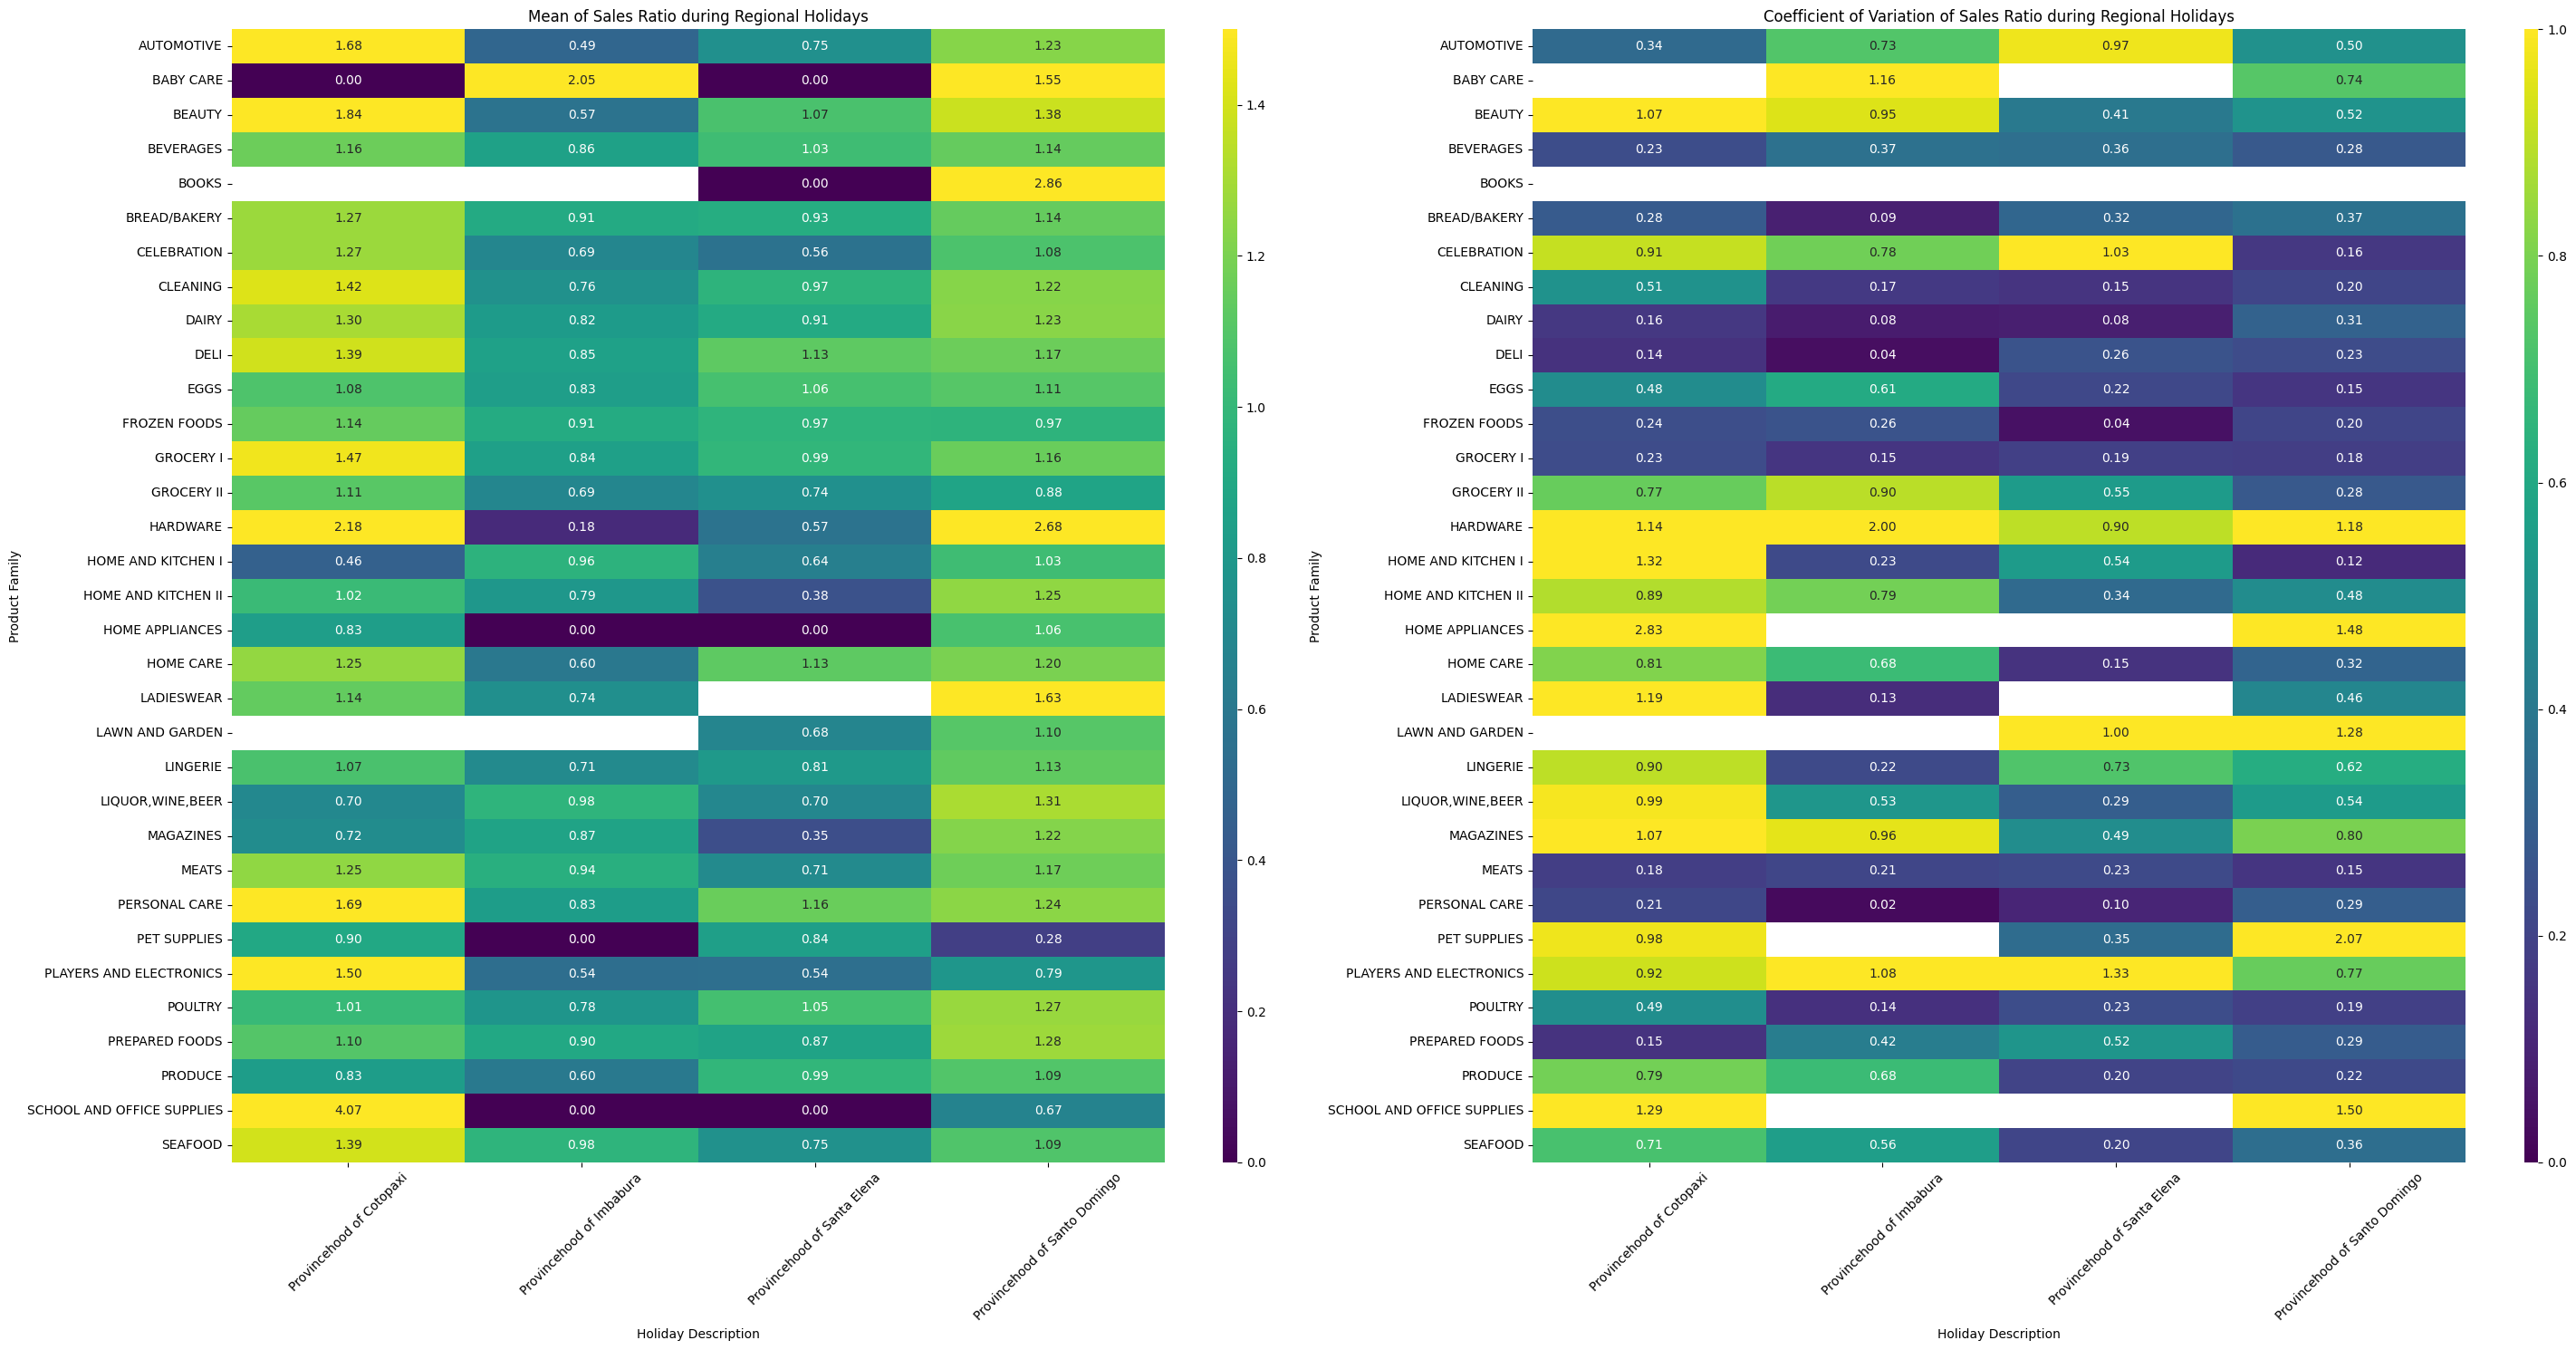

In [26]:
# Creates heatmap of sales ratio by regional holiday and product family

create_holiday_heatmaps(1, 2, (30, 15), 'Regional', 'Holiday')

Among the four regional holidays, Provincehood Day of Cotopaxi and Provincehood Day of Santo Domingo stand out by showing a notable increase in sales 
across certain product families. While the increase in sales indicates a meaningful local impact, several of these families also exhibit a high coefficient of variation along with a high mean, suggesting that the response is not consistently strong every year. This combination points to sporadic or event-driven spikes in consumer activity that may depend on local promotions, regional celebrations, or varying economic conditions.

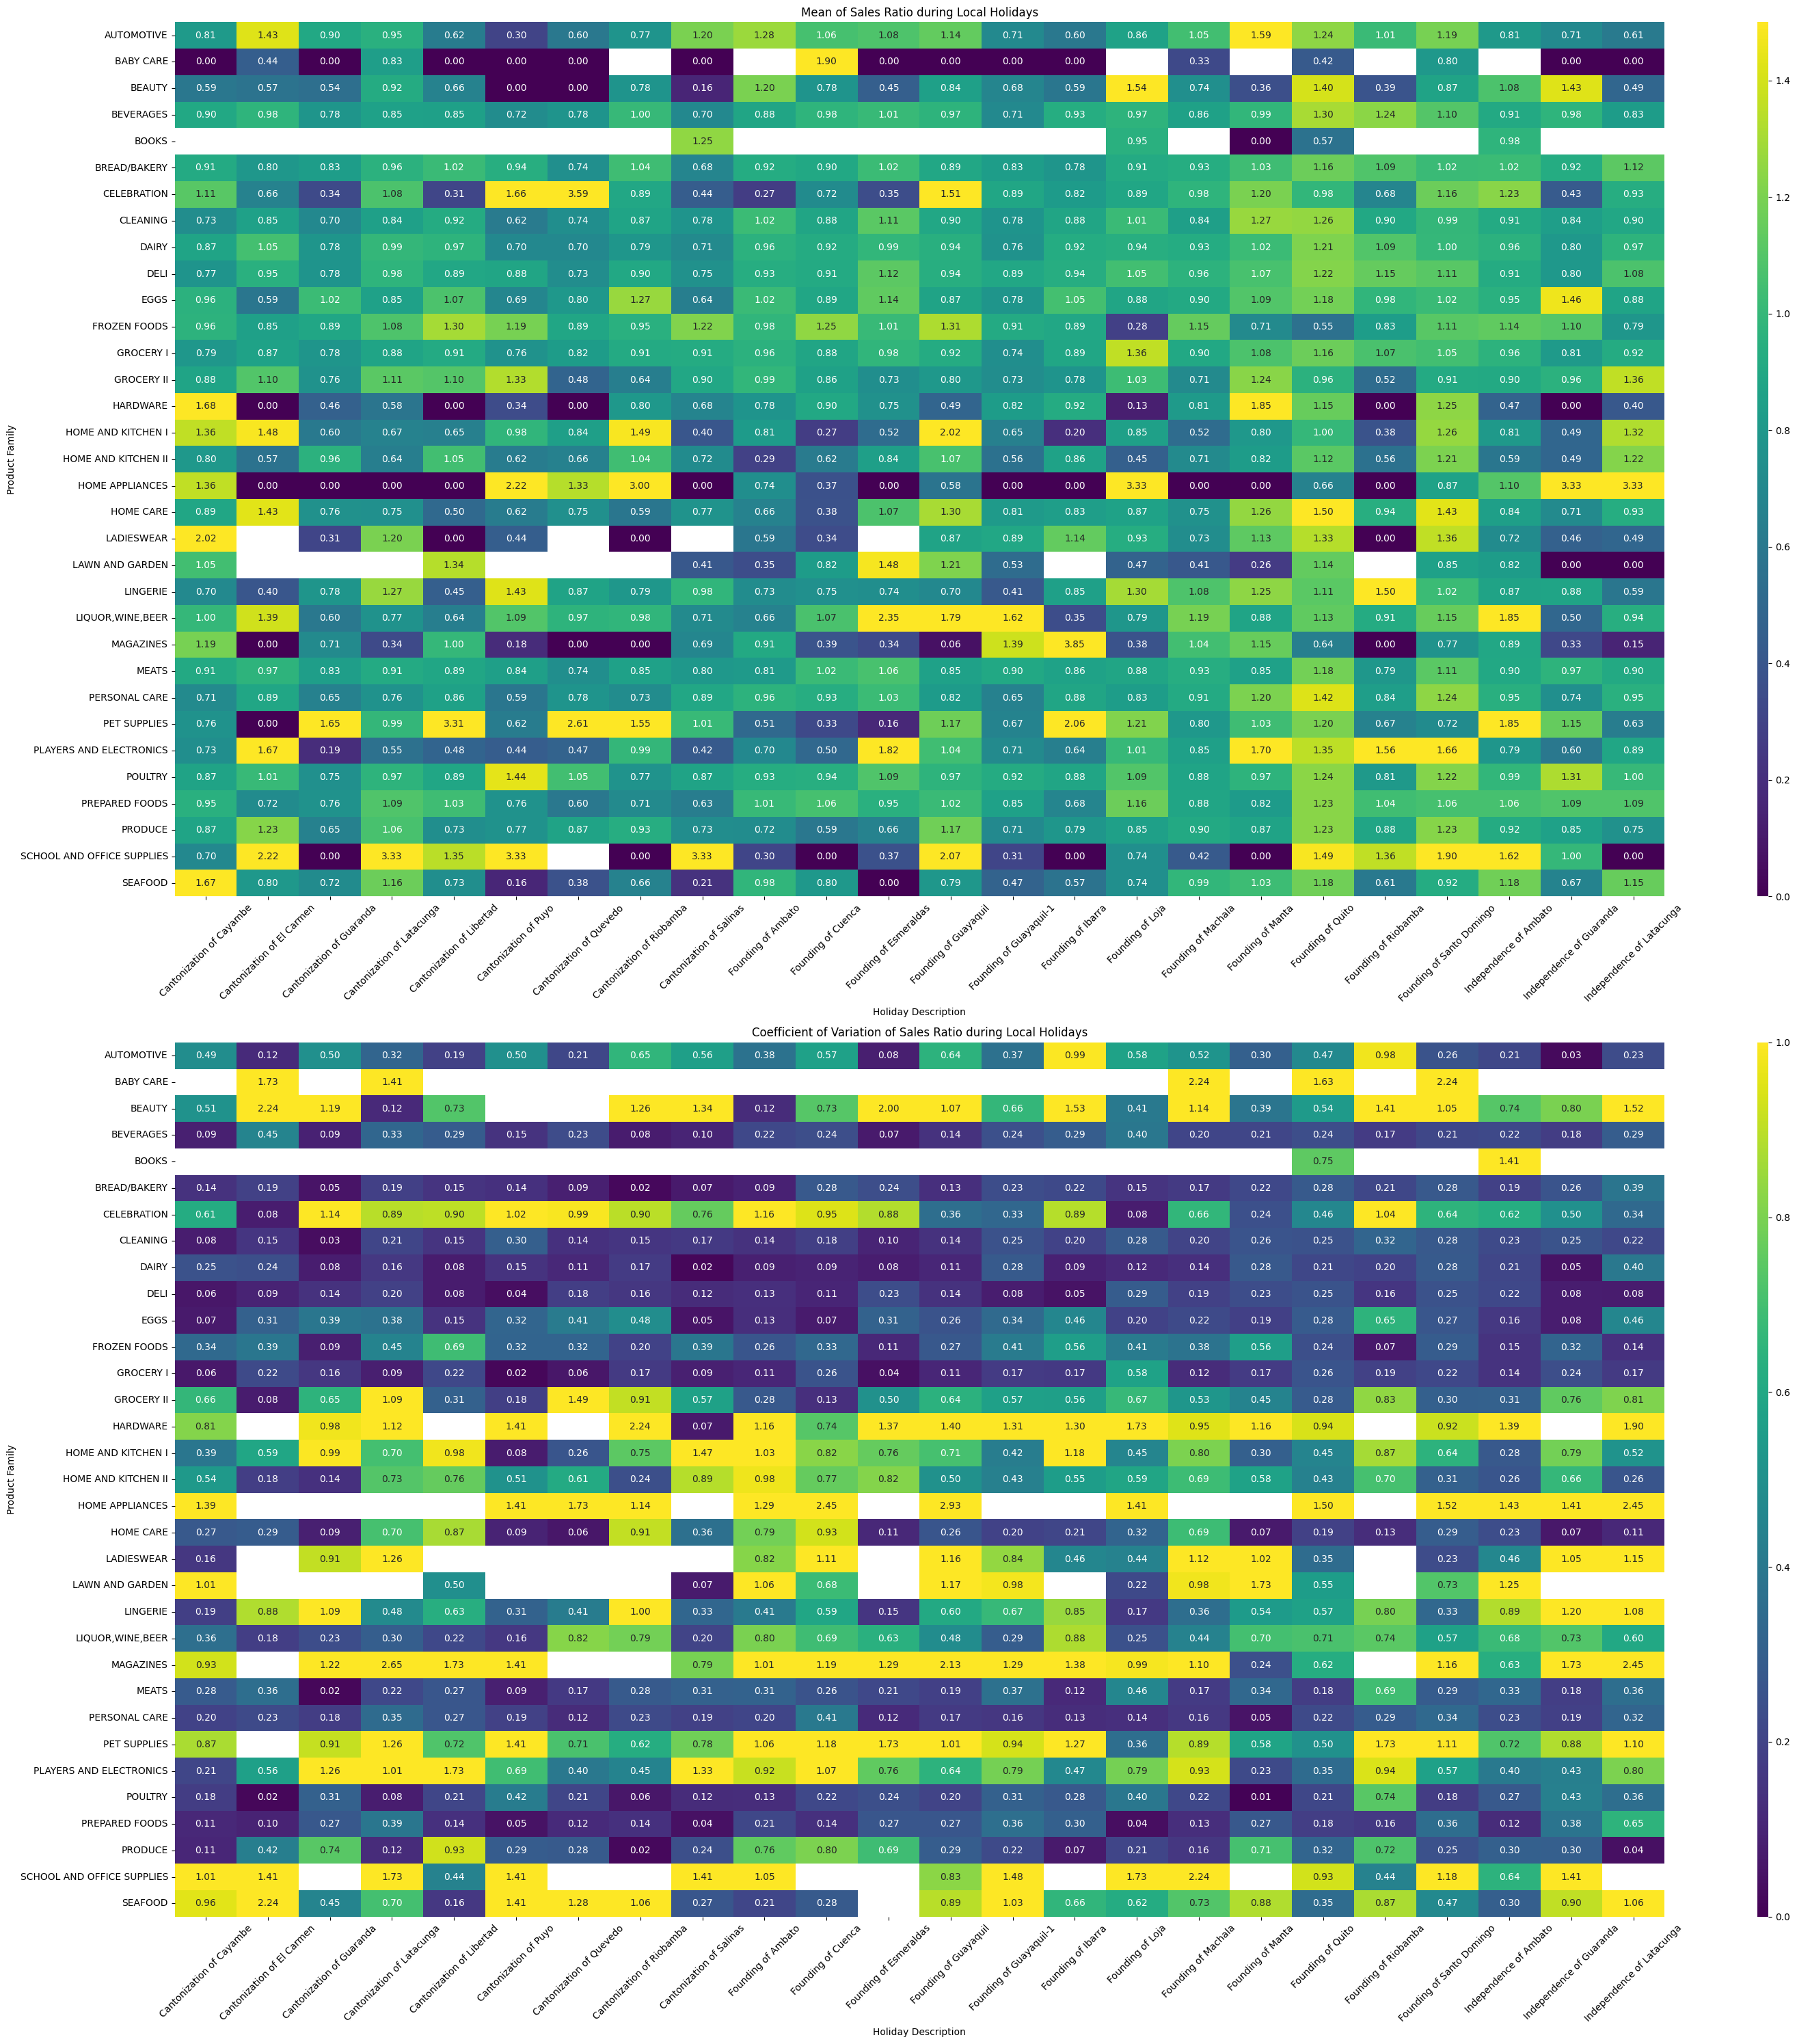

In [27]:
# Creates heatmap of sales ratio by local holiday and product family

create_holiday_heatmaps(2, 1, (30, 30), 'Local', 'Holiday')

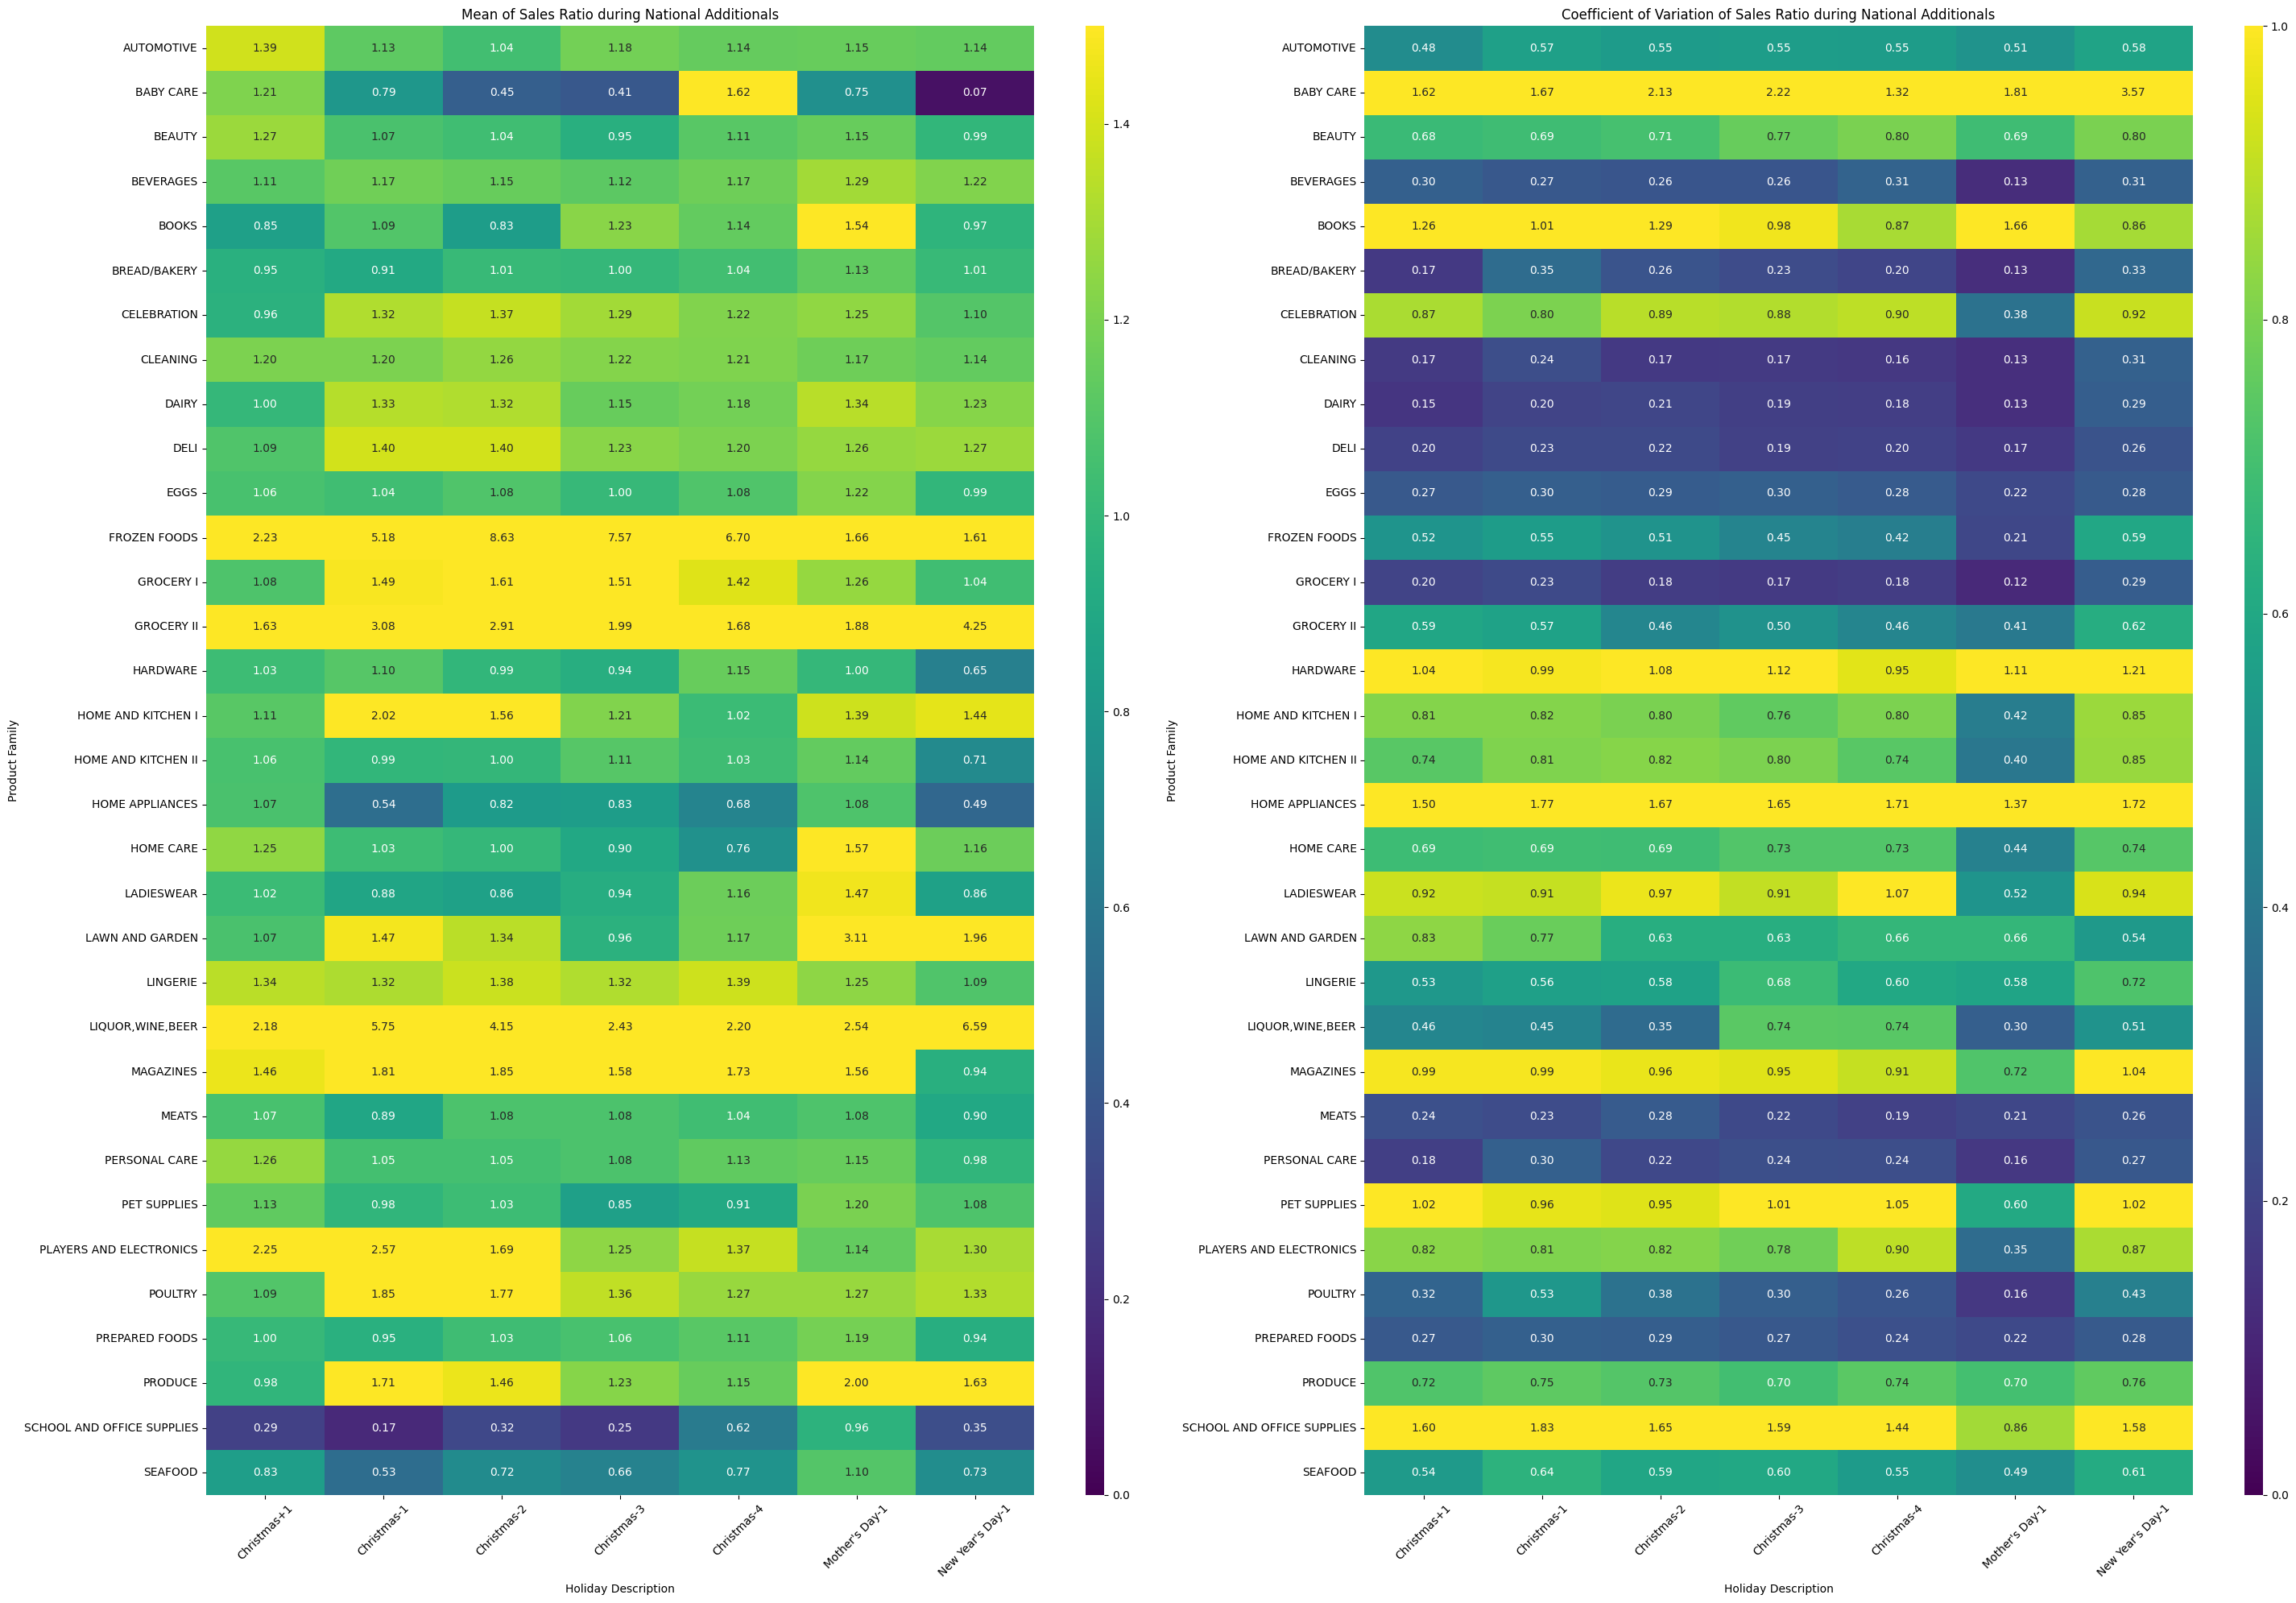

In [28]:
# Creates heatmap of sales ratio by national additional holiday and product family

create_holiday_heatmaps(1, 2, (30, 20), 'National', 'Additional')

As expected all the additional holidays experience high sales in liquor products, groceries and frozen foods, while on the day of additional holiday
for Mother's day lots of people buy lawn and garden items probably flowers and bouquets. These prodducts have low coefficient of variation, i.e, there
sales have been consistently high accross the years.

In [29]:
# Following code groups local holidays by product family based on their consistent impact on sales ratios.
# It calculates the mean and coefficient of variation (CV) of sales ratios for each family-holiday pair. Holidays are grouped if their sales impact (mean)
# meets a specified median_threshold (for either high or low sales) and their variability (CV) is below a cv_threshold. The output is a dictionary mapping 
# product families to their associated impactful holidays.

def group_similar_holidays(median_threshold, cv_threshold, filter_criteria):
    holidays_subset = holidays[(holidays['locale'] == 'Local') & (holidays['type'] == 'Holiday')]
    sr_df = create_sales_ratio(holidays_subset, 'Local')
    data = sr_df[(sr_df['locale'] == 'Local') & (sr_df['type_y'] == 'Holiday')]
    grouped = data.groupby(['family', 'description'])
    pivot_mean = grouped.apply(iqr_mean).unstack()
    pivot_cv = (grouped.apply(iqr_std) / grouped.apply(iqr_mean)).unstack()
    
    hol_array = []
    fam_array = []
    if filter_criteria == 'high_sales':
        condition_median = lambda mean_val: mean_val >= median_threshold 
    elif filter_criteria == 'low_sales':
        condition_median = lambda mean_val: mean_val <= median_threshold
    else:
        raise ValueError("Invalid filter_criteria. Choose 'high_sales' or 'low_sales'.")

    condition_cv = lambda cv_val: cv_val <= cv_threshold
    for row in range(pivot_mean.shape[0]):
        temp_array = []
        for col in range(pivot_mean.shape[1]):
            mean_val = pivot_mean.iloc[row, col]
            cv_val = pivot_cv.iloc[row, col]
            if condition_median(mean_val) & condition_cv(cv_val):
                temp_array.append(col)
        if temp_array:
            hol_array.append([pivot_mean.columns[j] for j in temp_array])
            fam_array.append(pivot_mean.index[row])

    dict_local_holidays = dict(zip(fam_array, hol_array))

    return dict_local_holidays

In [30]:
dict_local_hol_spike = group_similar_holidays(1.1, 0.8, 'high_sales')

dict_local_hol_drop = group_similar_holidays(0.9, 0.8, 'low_sales')

# FEATURE ENGINEERING

In [31]:
combined_df=pd.merge(train,stores,on=['store_nbr'],how='left')
combined_df=pd.merge(combined_df,oil,on=['date'],how='left')
combined_df=pd.merge(combined_df,transactions,on=['store_nbr','date'], how='left')
combined_df = combined_df.sort_values(by=['date','store_nbr', 'family'])

# Forward-fill for the selected columns
combined_df['dcoilwtico'] = combined_df.groupby(['store_nbr', 'family'])['dcoilwtico'].ffill()

# Backward-fill for the selected columns
combined_df['dcoilwtico'] = combined_df.groupby(['store_nbr', 'family'])['dcoilwtico'].bfill()

In [32]:
def create_lag_and_promo_features(df):
    df = df.sort_values(by='date')
    
    shift_values = list(range(1, 23)) + list(range(359, 366))

    for i in shift_values:
        df[f'shift_{i}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(i)

    df['transactions_lag'] = df.groupby(['store_nbr','family'])['transactions'].shift(16)

    combined_df.bfill(inplace=True, axis='rows')
    
    df['onpromotion_1'] = df.groupby(['store_nbr','family'])['onpromotion'].shift(1)
    df['onpromotion_2'] = df.groupby(['store_nbr','family'])['onpromotion'].shift(2)
    df['onpromotion_3'] = df.groupby(['store_nbr','family'])['onpromotion'].shift(3)


    df.sort_values(by=['date','store_nbr','family'], inplace = True)
    return df

In [33]:
def add_holiday_features(df_holidays ,df):
    
    holidays_copy = df_holidays.copy() 
    holidays_copy = holidays_copy[holidays_copy['transferred'] == False]
    
    merged_df = pd.merge(df, holidays_copy, left_on=['date','city'], right_on=['date','locale_name'], how='left')    
    for i,(family, holiday_grp) in enumerate(dict_local_hol_spike.items()):
        merged_df[f'local_holiday_spike_{i}'] = np.where((merged_df['family'] == family) & (merged_df['description'].isin(holiday_grp)),1,0)
        df_temp = merged_df[['date',f'local_holiday_spike_{i}','locale_name','family']].drop_duplicates()
        df = pd.merge(df,df_temp[df_temp[f'local_holiday_spike_{i}']==1], left_on=['date','city','family'], right_on=['date','locale_name','family'], how='left')
        df.drop(columns = 'locale_name', inplace=True)
    
    for i,(family, holiday_grp) in enumerate(dict_local_hol_drop.items()):
        merged_df[f'local_holiday_drop_{i}'] = np.where((merged_df['family'] == family) & (merged_df['description'].isin(holiday_grp)),1,0)
        df_temp = merged_df[['date',f'local_holiday_drop_{i}','locale_name','family']].drop_duplicates()
        df = pd.merge(df,df_temp[df_temp[f'local_holiday_drop_{i}']==1], left_on=['date','city','family'], right_on=['date','locale_name','family'], how='left')
        df.drop(columns = 'locale_name', inplace=True)
    
    holidays_copy['major_sales_event'] = (np.where((holidays_copy['description'].str.contains('Black Friday')) |
                                                 holidays_copy['description'].str.contains('Cyber Monday'),1,0))
    df_temp = holidays_copy[['date','major_sales_event']]
    df = pd.merge(df,df_temp[df_temp['major_sales_event']==1], on='date', how='left')
    
    holidays_copy['mothers_day'] = np.where(holidays_copy['description'].str.contains('Mother'),1,0)
    df_temp = holidays_copy[['date','mothers_day']]
    df = pd.merge(df,df_temp[df_temp['mothers_day']==1], on='date', how='left')
    
    holidays_copy['national_holiday'] = np.where((holidays_copy['locale'] == 'National') & (holidays_copy['type'] == 'Holiday'),1,0)
    df_temp = holidays_copy[['date','national_holiday']].drop_duplicates()
    df = pd.merge(df,df_temp[df_temp['national_holiday']==1], on='date', how='left')
    
    holidays_copy['football_event'] = np.where(holidays_copy['description'].str.contains('World Cup'),1,0)
    df_temp = holidays_copy[['date','football_event']].drop_duplicates()
    df = pd.merge(df,df_temp[df_temp['football_event']==1], on='date', how='left')
    
    holidays_copy['earthquake_relief'] = np.where(holidays_copy['description'].str.contains('Earthquake'),1,0)
    df_temp = holidays_copy[['date','earthquake_relief']].drop_duplicates()
    df = pd.merge(df,df_temp[df_temp['earthquake_relief']==1], on='date', how='left')
    
    holidays_copy['christmas'] = (np.where((holidays_copy['description'].str.contains('Christmas')) & 
                                          (~holidays_copy['description'].str.contains('Recovery Day Christmas Bridge')),1,0))
    df_temp = holidays_copy[['date','christmas']].drop_duplicates()
    df = pd.merge(df,df_temp[df_temp['christmas']==1], on='date', how='left')
    
    holidays_copy['new_year'] = (np.where((holidays_copy['description'].str.contains('New Year')) &
                                         (~holidays_copy['description'].str.contains("Recovery Day New Year's Bridge")),1,0))
    df_temp = holidays_copy[['date','new_year']].drop_duplicates()
    df = pd.merge(df,df_temp[df_temp['new_year']==1], on='date', how='left')

    holidays_copy['reg_holidays_1'] = (np.where((holidays_copy['description'].str.contains('Provincehood of Cotopaxi')) &
                                               (holidays_copy['description'].str.contains('Provincehood of Santo Domingo')),1,0))
    df_temp = holidays_copy[['date','reg_holidays_1']].drop_duplicates()
    df = pd.merge(df,df_temp[df_temp['reg_holidays_1']==1], on='date', how='left')

    holidays_copy['reg_holidays_2'] = (np.where((holidays_copy['description'].str.contains('Provincehood of Imbabura')) &
                                               (holidays_copy['description'].str.contains('Provincehood of Santa Elena')),1,0))
    df_temp = holidays_copy[['date','reg_holidays_2']].drop_duplicates()
    df = pd.merge(df,df_temp[df_temp['reg_holidays_2']==1], on='date', how='left')
    
    local_holiday_list_spike = [f'local_holiday_spike_{i}' for i in range(len(dict_local_hol_spike.items()))]
    local_holiday_list_drop = [f'local_holiday_drop_{i}' for i in range(len(dict_local_hol_drop.items()))]
    local_holiday_list = local_holiday_list_drop + local_holiday_list_spike
    holiday_list = ['national_holiday','major_sales_event','mothers_day','football_event','earthquake_relief',
                    'christmas','new_year', 'reg_holidays_1', 'reg_holidays_2'] + local_holiday_list 
    
    df[holiday_list] = df[holiday_list].fillna(0).astype(int)

    return df

In [34]:
def create_date_related_features(df):

    # Basic date attributes
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.day_of_week

    # One-hot encoding for months and weekdays
    df = pd.get_dummies(df, columns=['day_of_week'], prefix='day_of_week')
    df = pd.get_dummies(df, columns=['month'], prefix='month')

    #  Week of the month
    df['week_of_month'] = ((df['date'].dt.day - 1) // 7 + 1)
    df['is_first_week'] = (df['week_of_month'] == 1).astype(int)
    df['is_second_week'] = (df['week_of_month'] == 2).astype(int)
    df['is_third_week'] = (df['week_of_month'] == 3).astype(int)
    df['is_fourth_week'] = (df['week_of_month'] == 4).astype(int)

    # Year
    
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear

    df['day_of_month'] = df['date'].dt.day
    
    return df


In [35]:
def create_ewma(data, col='sales'):
    
    df = data.copy()
    df.sort_values(by=['date', 'family',  'store_nbr'], inplace=True)
    
    # # Lag by 1, then EWMA with span=4
    df['ewma_span4_lag1'] = (
        df.groupby(['store_nbr', 'family'])[col]
        .transform(lambda x: x.shift(1).ewm(span=4, adjust=False, min_periods=1).mean())
    )
    
    # # Lag by 1, then EWMA with span=30
    df['ewma_span30_lag1'] = (
        df.groupby(['store_nbr', 'family'])[col]
        .transform(lambda x: x.shift(1).ewm(span=30, adjust=False, min_periods=1).mean())
    )

    # Lag by 16, then EWMA with span=4
    df['ewma_span4_lag16'] = (
        df.groupby(['store_nbr', 'family'])[col]
        .transform(lambda x: x.shift(16).ewm(span=4, adjust=False, min_periods=1).mean())
    )

    # Lag by 16, then EWMA with span=30
    df['ewma_span30_lag16'] = (
        df.groupby(['store_nbr', 'family'])[col]
        .transform(lambda x: x.shift(16).ewm(span=30, adjust=False, min_periods=1).mean())
    )

    # Lag by 365, then EWMA with span=4
    df['ewma_span4_lag365'] = (
        df.groupby(['store_nbr', 'family'])[col]
        .transform(lambda x: x.shift(365).ewm(span=4, adjust=False, min_periods=1).mean())
    )

    # Lag by 365, then EWMA with span=30
    df['ewma_span30_lag365'] = (
        df.groupby(['store_nbr', 'family'])[col]
        .transform(lambda x: x.shift(365).ewm(span=30, adjust=False, min_periods=1).mean())
    )

    df.sort_values(by=['date', 'store_nbr', 'family'], inplace=True)
    return df

In [36]:
def create_date_rolling_mean(data, col = 'sales'):
    df = data.copy()
    
    df['day_of_week'] = df['date'].dt.day_of_week
    df['weekday_mean'] = (
        df.groupby(['store_nbr','family','day_of_week'])[col]
        .transform(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
    )

    df['month'] = df['date'].dt.month
    df['month_encoded'] = (
        df.groupby(['store_nbr','family','month'])[col]
        .transform(lambda x: x.shift(1).rolling(window=60, min_periods=1).mean())
    )

    df.sort_values(by=['date','store_nbr','family'], inplace = True)
    return df

In [37]:
combined_df = create_lag_and_promo_features(combined_df)

combined_df = create_date_related_features(combined_df)

combined_df = create_ewma(combined_df)

combined_df = create_date_rolling_mean(combined_df)

combined_df = add_holiday_features(holidays, combined_df)

print(combined_df.shape[0])

3000888


In [38]:
lag_list = [f'shift_{i}' for i in range(1,8)]
lag_list_16 = [f'shift_{i}' for i in range(16,23)]
lag_list_365 = [f'shift_{i}' for i in range(359, 366)]

# Following three lists of lag features are used for multi-output prediction.
lag_list_multioutput_pred = [f'shift_{i}' for i in range(1,17)]

weekday_list = [f'day_of_week_{i}' for i in range(7)]

month_list = [f'month_{i+1}' for i in range(12)]
day_list = [f'day_{i+1}' for i in range(31)]
local_holiday_list_spike = [f'local_holiday_spike_{i}' for i in range(len(dict_local_hol_spike.items()))]
local_holiday_list_drop = [f'local_holiday_drop_{i}' for i in range(len(dict_local_hol_drop.items()))]
local_holiday_list = local_holiday_list_drop + local_holiday_list_spike
holiday_list = ['national_holiday','major_sales_event','mothers_day','football_event','earthquake_relief','christmas',
                'new_year','reg_holidays_1', 'reg_holidays_2'] + local_holiday_list 
    

feature_list = lag_list + weekday_list + lag_list_16 + lag_list_365 + holiday_list + ['day_of_month','day_of_year','onpromotion', 
                        'dcoilwtico','transactions_lag','ewma_span4_lag1', 'ewma_span30_lag1', 'onpromotion_1','onpromotion_2',
                        'onpromotion_3','year','weekday_mean','month_encoded','ewma_span4_lag16', 'ewma_span30_lag16','is_first_week',
                        'is_second_week','is_third_week','is_fourth_week','ewma_span4_lag365', 'ewma_span30_lag365']

# MODEL

In [39]:
%load_ext cudf.pandas

To calculate two of the exponentially weighted moving averages, we need the past sales data, starting from the day before the current date. Since the forecast 
period spans 16 days, only the first forecast day would not require predicted lag values, the rest would. To obtain these lag values (and thereby compute
ewma), we use a multi-output regressor to predict sales for future dates based on past sales. While these predictions may not be highly accurate,
the goal is that they are close enough to guide the model toward the correct decision tree splits during final pred.

In [40]:
def create_multistep_targets(df, target_col, steps=16):
    """
    Create multi-step target columns for a given target column in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - target_col (str): The target column for which multi-step columns will be created.
    - steps (int): The number of steps ahead to create targets for.

    Returns:
    - pd.DataFrame: The DataFrame with additional multi-step target columns.
    """
    df_copy = df.copy()  # Avoid modifying the original DataFrame
    df_copy.sort_values(by=['date','store_nbr'])

    # Create multi-step target columns
    for step in range(1, steps + 1):
        df[f'{target_col}_step_{step}'] = df.groupby(['store_nbr', 'family'])[target_col].shift(-step)

    return df

In [41]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
#tree_method="gpu_hist",
base_model = xgb.XGBRegressor( learning_rate=0.05, max_depth=7, min_child_weight=100, subsample= 0.7, colsample_bytree= 0.7,
                              n_estimators= 150, random_state=42)

# Features for multistep prediction
multistep_features = (['ewma_span4_lag1','ewma_span30_lag1','month_encoded','weekday_mean','sales','onpromotion','transactions'] + lag_list_multioutput_pred
                      + weekday_list)

In [42]:
# Predicts sales values for the 16 days in the forecast range using past sales values

def create_model_for_multistep_sales(data, future_window=16):
    df_multi = data.copy()
    df_multi = create_multistep_targets(df_multi,'sales',future_window)
    
    df_multi.dropna(inplace=True)
    multi_targets=[f'sales_step_{i}' for i in range(1,future_window+1)]

    df_multi['days_to_go'] = (df_multi['date'].max() - df_multi['date']).dt.days
    df_multi['recency_weight'] = 1 / (df_multi['days_to_go'] + 1)**0.1  # Higher weight for recent dates
    weight_list = df_multi['recency_weight']
        
    x_multi=df_multi[multistep_features]
    
    y_multi=df_multi[multi_targets]
    y_multi=np.log1p(y_multi)
        
    model_sales = MultiOutputRegressor(base_model)
    model_sales.fit(x_multi, y_multi, sample_weight = weight_list)
    return model_sales

In [43]:
# Predicts ewmas for the 16 days in the forecast range

def create_model_for_ewma_prediction(data, ewma_col_list, past_window=16, future_window=16):
    
    df = data.copy()
    # Add group column for segmentation
    df['group'] = df['store_nbr'].astype(str) + "_" + df['family']
    df = df.sort_values(by=['date', 'store_nbr', 'family'])

    lag = 1
    model_dict = {}
    for ewma_col in ewma_col_list:
        df = create_multistep_targets(df, ewma_col, future_window)
        for i in range(lag, past_window + lag):
            df[f'{ewma_col}_lag_{i}'] = df.groupby(['store_nbr', 'family'])[ewma_col].shift(i)
    
        ewma_lag_cols = [f'{ewma_col}_lag_{i}' for i in range(lag, past_window + lag)]
        
        ewma_feature_list = ewma_lag_cols + list(set(multistep_features)-set(lag_list_multioutput_pred))
        target_cols = [f'{ewma_col}_step_{i}' for i in range(1, future_window + 1)]

        # Drop rows with NaN values    
        df.dropna(inplace=True)

        df['days_to_go'] = (df['date'].max() - df['date']).dt.days
        df['recency_weight'] = 1 / (df['days_to_go'] + 1)**0.1  # Higher weight for recent dates
        weight_list = df['recency_weight']

        X = df[ewma_feature_list]
        y = df[target_cols]
        y = np.log1p(y)
        
        # Train the model
        model_dict[ewma_col] = MultiOutputRegressor(base_model)
        model_dict[ewma_col].fit(X, y , sample_weight = weight_list)
            
    return model_dict

In [44]:
# To validate the model, the data needs to be split into training and validation sets. The sales in the validation set cannot be used as lag values, neither 
# can they be used to calculate rolling means as it would cause data leakage. In order to avoid this, actual sales in the validation set will be replaced by
# predicted sales from the multi-output regressor. Then these predicted values will be used to fill in the lag values. Same will be done for rolling means.
# THe following code does exactly the same: fills in the lag values and exponentially weighted moving average with predicted values.


def fill_columns_for_test(train_df, test_df, steps=16):

    test_df_copy = test_df.copy()
    test_df_copy = test_df_copy.sort_values(by=['store_nbr', 'family', 'date'])
    
    # Initialize models
    
    sales_model = create_model_for_multistep_sales(train_df)
    
    ewma_model_dict = create_model_for_ewma_prediction(train_df, ['ewma_span4_lag1', 'ewma_span30_lag1'])
    
    # Iterate through each store-family combination
    for store in test_df_copy['store_nbr'].unique():
        temp_train = train_df[train_df['store_nbr'] == store]
        temp_test = test_df_copy[test_df_copy['store_nbr'] == store]
        for family in temp_test['family'].unique():
            train_subset = temp_train[temp_train['family'] == family]
            test_subset = temp_test[temp_test['family'] == family]

            if train_subset.empty:
                continue

            # Predict and update ewma features
            past_window = 16
            lag = 1
            for ewma_col in ['ewma_span4_lag1', 'ewma_span30_lag1']:
                predictions = []             

                for i in range(lag, past_window + lag):
                    train_subset[f'{ewma_col}_lag_{i}'] = train_subset.groupby(['store_nbr', 'family'])[ewma_col].shift(i)
                last_train_row = train_subset.sort_values(by='date').iloc[-1]    
                ewma_lag_cols = [f'{ewma_col}_lag_{i}' for i in range(lag, past_window + lag)]
                ewma_feature_list = ewma_lag_cols + list(set(multistep_features)-set(lag_list_multioutput_pred))
                X_last_roll = last_train_row[ewma_feature_list].values.reshape(1, -1)
                y_pred_ewma = ewma_model_dict[ewma_col].predict(X_last_roll).flatten()

                y_pred_ewma = np.exp(y_pred_ewma) - 1
                    
                for i in range(steps):
                    if i < len(test_subset):
                        idx = test_subset.index[i]
                        test_df_copy.loc[idx, ewma_col] = y_pred_ewma[i] if i < len(y_pred_ewma) else None

            # Predict and update sales and transactions

            last_train_row = train_subset.sort_values(by='date').iloc[-1]                
            X_last_lag = last_train_row[multistep_features].values.reshape(1, -1)
            y_pred_sales = sales_model.predict(X_last_lag).flatten()
            y_pred_sales = np.exp(y_pred_sales) - 1
                            
            for i in range(steps):
                if i < len(test_subset):
                    idx = test_subset.index[i]
                    test_df_copy.loc[idx, 'sales_temp'] = y_pred_sales[i] if i < len(y_pred_sales) else None

    # Update lag features across train and test
    train_df_copy = train_df.copy()
    train_df_copy['sales_temp'] = train_df_copy['sales'].copy()
    test_df_copy['sales_temp'] = test_df_copy['sales_temp'].clip(lower=0)
    merged_df = pd.concat([train_df_copy, test_df_copy]).sort_values('date').reset_index(drop=True)

    for i in range(1,8):
        merged_df[f'shift_{i}'] = merged_df.groupby(['store_nbr', 'family'])['sales_temp'].shift(i)

    # merged_df = create_rolling_mean(merged_df,'sales_temp')
    merged_df = create_date_rolling_mean(merged_df,'sales_temp')

    test_df_final = merged_df[merged_df['date'] >= test_df_copy['date'].min()].sort_values(by=['date','store_nbr','family'])
    return test_df_final[test_df.columns]


In [45]:
def expanding_window_validation_with_predicted_lags(data, target_col, model, train_date_bound, test_date_bound):

    results = []

    # Define training and test indices
    train_start, train_end = train_date_bound
    test_start, test_end = test_date_bound
    
    train_start = pd.to_datetime(train_start)
    train_end = pd.to_datetime(train_end)
    test_start = pd.to_datetime(test_start)
    test_end = pd.to_datetime(test_end)
    n_splits = (test_end - train_end).days // 16
    
    data = data.sort_values(['date','store_nbr','family']).reset_index(drop=True)

    for fold in range(n_splits):

        curr_train_end = train_end + pd.Timedelta(days=16*fold)
        test_start = curr_train_end + pd.Timedelta(days=1)
        test_end = curr_train_end + pd.Timedelta(days=16)

        # Split the data
        train_data = data[(data['date']>=train_start) & (data['date']<=curr_train_end)].copy()
    
        # Calculate 'days_to_go' as the difference between max date and each date
        train_data['days_to_go'] = (train_data['date'].max() - train_data['date']).dt.days
    
        # Create weights inversely proportional to 'days_to_go'
        # Add 1 to avoid division by zero
        train_data['recency_weight'] = 1 / (train_data['days_to_go'] + 1)**0.5  # Higher weight for recent dates
    
        train_data['combined_weight'] = train_data['recency_weight']
        
        test_data = data[(data['date']>=test_start) & (data['date']<=test_end)].copy()

        test_data = fill_columns_for_test(train_data, test_data)
    
        weight_list = train_data['combined_weight']
    
        train_data['sales'] = np.log1p(train_data['sales'])  # log(1 + sales)
        
        # Separate features and target
        X_train, y_train = train_data[feature_list],train_data[target_col]
        X_test, y_test = test_data[feature_list], test_data[target_col]

        prediction = []
        final_prediction = []

        lag_cols = ['ewma_span4_lag1','ewma_span30_lag1']+lag_list
        lag16_cols = ['ewma_span4_lag16','ewma_span30_lag16']+lag_list_16
        lag365_cols = ['ewma_span4_lag365','ewma_span30_lag365']+lag_list_365
        
        for columns_to_discard in [lag365_cols+lag16_cols, lag_cols+lag365_cols, lag_cols+lag16_cols]:

            x_train = X_train.drop(columns=columns_to_discard, errors='ignore')
            x_test = X_test.drop(columns=columns_to_discard, errors='ignore')
            
            # Train the model
            main_model.fit(x_train, y_train, sample_weight = weight_list)

            # Predict and evaluate
            y_pred = main_model.predict(x_test)
            y_pred=np.exp(y_pred)-1
            y_pred=np.where(y_pred<0,0,y_pred)
            prediction.append(y_pred)

        for i in range(len(X_test)):
            num = int(i/54)
            weight = (16-num)/16
            result = (prediction[0][i]*weight + prediction[1][i]*(1-weight))*0.7 + prediction[2][i]*0.3
            final_prediction.append(result)
        
        rmsle = mean_squared_log_error(y_test, final_prediction, squared=False)
    
        # Store results
        results.append({
            'fold': fold,
            'train_start': train_start,
            'train_end': curr_train_end,
            'test_start': test_start,
            'test_end': test_end,
            'rmsle': rmsle,
        })

    return results

In [46]:
main_model = xgb.XGBRegressor(device="gpu", learning_rate=0.01, max_depth=10, min_child_weight=3, subsample= 0.9, colsample_bytree= 0.8,
                         n_estimators= 1000, random_state=42)

In [47]:
# Initialize fold error tracker
from collections import defaultdict
fold_error = defaultdict(list)

fam_list = combined_df['family'].unique()

for fam_member in fam_list:
    print(f'######################################################################################################################')
    print(f"\nProcessing Family: {fam_member}")

    family_group = combined_df[combined_df['family'] == fam_member]
    
    # Filter data for the current family
    family_subset = (family_group[feature_list + ['id', 'date', 'family', 'store_nbr', 'sales', 'transactions'] + 
               [f'shift_{i}' for i in list(range(8,16))]]
              )
    # Define expanding window parameters
    train_date_bound = [family_subset['date'].min(), family_subset['date'].max() + pd.Timedelta(days=-16*3)]
    test_date_bound = [family_subset['date'].max() + pd.Timedelta(days=-16*3+1), family_subset['date'].max()]
    
    # Perform expanding window validation
    results = expanding_window_validation_with_predicted_lags(family_subset, 'sales', main_model, train_date_bound, test_date_bound)

    family_fold_error = []
    # Log fold results and store errors
    for fold_result in results:
        fold = fold_result['fold']
        rmsle = fold_result['rmsle']
        print(
            f"Fold {fold}: Train: {fold_result['train_start'].date()}-{fold_result['train_end'].date()} | "
            f"Test: {fold_result['test_start'].date()}-{fold_result['test_end'].date()} | RMSLE: {rmsle:.4f}"
        )
        fold_error[fold].append(rmsle)
        family_fold_error.append(rmsle)
    
    # Summarize errors
    
    print(f"Average RMSLE for family {fam_member}: {np.mean(family_fold_error, axis=0):.4f}")
    
for fold in fold_error.keys():
    print(f"Average RMSLE for fold-{fold}: {np.mean(fold_error[fold], axis=0):.4f}")
all_rmsle = [r for rmsles in fold_error.values() for r in rmsles]
avg_rmsle = sum(all_rmsle) / len(all_rmsle) if all_rmsle else float('nan')
print(f"Overall Average RMSLE: {avg_rmsle:.4f}")

######################################################################################################################

Processing Family: AUTOMOTIVE
Fold 0: Train: 2013-01-01-2017-06-28 | Test: 2017-06-29-2017-07-14 | RMSLE: 0.5054
Fold 1: Train: 2013-01-01-2017-07-14 | Test: 2017-07-15-2017-07-30 | RMSLE: 0.4816
Fold 2: Train: 2013-01-01-2017-07-30 | Test: 2017-07-31-2017-08-15 | RMSLE: 0.5125
Average RMSLE for family AUTOMOTIVE: 0.4998
######################################################################################################################

Processing Family: BABY CARE
Fold 0: Train: 2013-01-01-2017-06-28 | Test: 2017-06-29-2017-07-14 | RMSLE: 0.3089
Fold 1: Train: 2013-01-01-2017-07-14 | Test: 2017-07-15-2017-07-30 | RMSLE: 0.2762
Fold 2: Train: 2013-01-01-2017-07-30 | Test: 2017-07-31-2017-08-15 | RMSLE: 0.2874
Average RMSLE for family BABY CARE: 0.2908
####################################################################################################################

# PREDICTION

In [48]:
combined_df_test=pd.merge(test,stores,on=['store_nbr'],how='left')
combined_df_test=pd.merge(combined_df_test,oil,on=['date'],how='left')
combined_df_test=pd.merge(combined_df_test,transactions,on=['store_nbr','date'],how='left')

In [49]:
# Forward-fill for the selected columns
combined_df_test['dcoilwtico'] = combined_df_test.groupby(['store_nbr', 'family'])[['dcoilwtico']].ffill()

# Backward-fill for the selected columns
combined_df_test['dcoilwtico'] = combined_df_test.groupby(['store_nbr', 'family'])[['dcoilwtico']].bfill()

In [50]:
combined_df_test = add_holiday_features(holidays, combined_df_test)
combined_df_test = create_date_related_features(combined_df_test)

concat_df=pd.concat([combined_df,combined_df_test])

concat_df_encoded = create_lag_and_promo_features(concat_df)
concat_df_encoded = create_ewma(concat_df_encoded)

first_test_date = test['date'].min()
test_df_encoded = concat_df_encoded[concat_df_encoded['date']>=first_test_date]

combined_df_test = test_df_encoded.copy()

In [51]:
combined_df_test.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster',
       ...
       'local_holiday_drop_28', 'major_sales_event', 'mothers_day',
       'national_holiday', 'football_event', 'earthquake_relief', 'christmas',
       'new_year', 'reg_holidays_1', 'reg_holidays_2'],
      dtype='object', length=149)

In [52]:
main_model = xgb.XGBRegressor(device="gpu", learning_rate=0.01, max_depth=10, min_child_weight=3, subsample= 0.9, colsample_bytree= 0.8,
                         n_estimators= 1000, random_state=42)
concat_output = pd.DataFrame(columns=['id','sales'])
family_list = combined_df['family'].unique()
for member in family_list:
    print(member)
    train_subset = combined_df[combined_df['family']==member]
    test_subset = combined_df_test[combined_df_test['family']==member]
    prep_test_subset = fill_columns_for_test(train_subset, test_subset)    

    train_subset['days_to_go'] = (train_subset['date'].max() - train_subset['date']).dt.days
    train_subset['recency_weight'] = 1 / (train_subset['days_to_go'] + 1)**0.5
    weights = train_subset['recency_weight']
    train_subset.drop(columns=['recency_weight','days_to_go'],inplace=True)

    prediction = []
    final_prediction = []

    lag_cols = ['ewma_span4_lag1','ewma_span30_lag1']+lag_list
    lag16_cols = ['ewma_span4_lag16','ewma_span30_lag16']+lag_list_16
    lag365_cols = ['ewma_span4_lag365','ewma_span30_lag365']+lag_list_365

    y_train = np.log1p(train_subset['sales'])
        
    for columns_to_discard in [lag365_cols+lag16_cols, lag_cols+lag365_cols, lag_cols+lag16_cols]:

        x_train = train_subset[feature_list].drop(columns=columns_to_discard, errors='ignore')
        x_test = prep_test_subset[feature_list].drop(columns=columns_to_discard, errors='ignore')

        # Train the model
        main_model.fit(x_train, y_train, sample_weight = weights)

        # Predict and evaluate
        y_pred = main_model.predict(x_test)
        y_pred=np.exp(y_pred)-1
        y_pred=np.where(y_pred<0,0,y_pred)
        prediction.append(y_pred)
    
    for i in range(len(x_test)):
        num = int(i/54)
        weight = (16-num)/16
        result = (prediction[0][i]*weight + prediction[1][i]*(1-weight))*0.7 + prediction[2][i]*0.3
        final_prediction.append(result)
        
    prep_test_subset['sales'] = final_prediction
    
    output = prep_test_subset[['id','sales']]
    output['id'] = output['id'].astype(int)

    concat_output = pd.concat([concat_output,output])

AUTOMOTIVE
BABY CARE
BEAUTY
BEVERAGES
BOOKS
BREAD/BAKERY
CELEBRATION
CLEANING
DAIRY
DELI
EGGS
FROZEN FOODS
GROCERY I
GROCERY II
HARDWARE
HOME AND KITCHEN I
HOME AND KITCHEN II
HOME APPLIANCES
HOME CARE
LADIESWEAR
LAWN AND GARDEN
LINGERIE
LIQUOR,WINE,BEER
MAGAZINES
MEATS
PERSONAL CARE
PET SUPPLIES
PLAYERS AND ELECTRONICS
POULTRY
PREPARED FOODS
PRODUCE
SCHOOL AND OFFICE SUPPLIES
SEAFOOD


In [53]:
concat_output.sort_values('id',inplace=True)

In [54]:
concat_output.to_csv('submission.csv',index=False)